In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from datetime import datetime
import json
import fitsio
import pandas as pd
import time
import pickle

%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/hurra/Projects/survey-ops')
# sys.path.append('/home/rachel/Projects/survey-ops')


In [3]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.environments import *
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [4]:
seed_everything(10)

# Load and cut data from fits file, save as .json

In [5]:
data_json_fn = '../data/data.json'
data_fits_fn = '../data/decam-exposures-20251107.fits.gz'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read('../data/decam-exposures-20251107.fits.gz')
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    print(df['datetime'].dtype)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Configure model, data selection, and training setup

In [6]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [7]:
dataset = OfflineDECamDataset(
    df, 
    binning_method='healpix',
    nside=8,
    normalize_state=True,
    specific_years=[2014],
    specific_months=[8],
    # specific_days=np.arange(2, 4),
    # specific_filters=['r', 'g']
)

In [8]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [9]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 100,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Visualize dataset in (az, el) and binning sizes

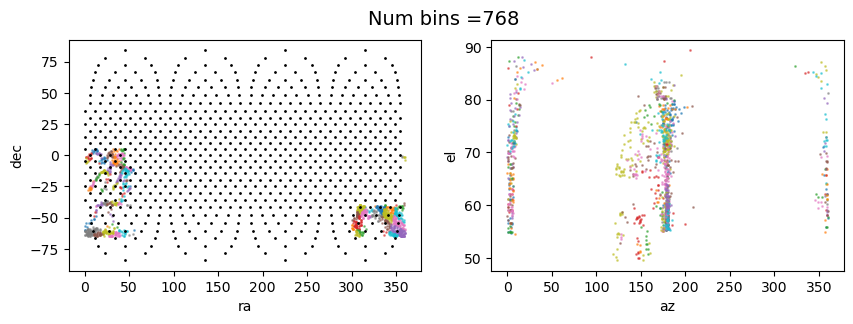

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,3))

for bin_id in np.unique(dataset.actions):
    mask = dataset.actions == bin_id
    axs[0].scatter(dataset.next_states[mask, dataset.statename2idx['ra']] * dataset.stds[dataset.statename2idx['ra']] + dataset.means[dataset.statename2idx['ra']],
                dataset.next_states[mask, dataset.statename2idx['dec']] * dataset.stds[dataset.statename2idx['dec']] + dataset.means[dataset.statename2idx['dec']],
                s=1,
                alpha=.5
                )
axs[0].scatter(dataset.hpGrid.lon/units.deg, dataset.hpGrid.lat/units.deg, color='black', s=1)
axs[0].set_xlabel('ra')
axs[0].set_ylabel('dec')

for bin_id in np.unique(dataset.actions):
    mask = dataset.actions == bin_id
    axs[1].scatter(dataset.next_states[mask, dataset.statename2idx['az']] * dataset.stds[dataset.statename2idx['az']] + dataset.means[dataset.statename2idx['az']],
                dataset.next_states[mask, dataset.statename2idx['el']] * dataset.stds[dataset.statename2idx['el']] + dataset.means[dataset.statename2idx['el']],
                s=1,
                alpha=.5
                )
axs[1].set_xlabel('az')
axs[1].set_ylabel('el')

fig.suptitle(f'Num bins ={dataset.num_actions}', fontsize=14)
fig.savefig(fig_outdir + 'plot_observations_in_sky_colored_bins.png')

In [11]:
dataset.save_schedule_for_video(outdir=outdir)

# Train

In [31]:
# losses = []
# q_values = []
# loader_iter = iter(trainloader)
# batch = next(loader_iter)
# obs, expert_actions = batch[0:2]
# obs = obs.to(device, torch.float32)
# expert_actions = expert_actions.to(device, torch.long)
# action_logits = alg.policy_net(obs)

# loss = alg.loss_fxn(action_logits, expert_actions)


In [32]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|                                                | 0/130900 [00:00<?, ?it/s]/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device)
  0%|                                     | 132/130900 [00:00<02:57, 734.75it/s]

Train step 0: Accuracy = 0.000, Loss = 6.6692
Train step 100: Accuracy = 0.375, Loss = 1.8738
Train step 200: Accuracy = 0.562, Loss = 1.7487


  0%|▏                                   | 474/130900 [00:00<02:04, 1049.87it/s]

Train step 300: Accuracy = 0.656, Loss = 1.0826
Train step 400: Accuracy = 0.531, Loss = 0.9673
Train step 500: Accuracy = 0.719, Loss = 1.0940


  1%|▏                                   | 823/130900 [00:00<01:55, 1125.76it/s]

Train step 600: Accuracy = 0.688, Loss = 1.0347
Train step 700: Accuracy = 0.688, Loss = 0.8945
Train step 800: Accuracy = 0.719, Loss = 0.7954


  1%|▎                                  | 1049/130900 [00:01<01:56, 1114.68it/s]

Train step 900: Accuracy = 0.500, Loss = 0.5355
Train step 1000: Accuracy = 0.781, Loss = 1.1111
Train step 1100: Accuracy = 0.750, Loss = 0.9184


  1%|▎                                  | 1394/130900 [00:01<01:53, 1136.23it/s]

Train step 1200: Accuracy = 0.875, Loss = 1.0103
Train step 1300: Accuracy = 0.719, Loss = 0.8117
Train step 1400: Accuracy = 0.625, Loss = 0.7982


  1%|▍                                  | 1633/130900 [00:01<01:50, 1167.56it/s]

Train step 1500: Accuracy = 0.812, Loss = 0.7094
Train step 1600: Accuracy = 0.750, Loss = 0.6395
Train step 1700: Accuracy = 0.688, Loss = 0.7985


  2%|▌                                  | 1985/130900 [00:01<01:51, 1158.83it/s]

Train step 1800: Accuracy = 0.750, Loss = 0.6884
Train step 1900: Accuracy = 0.750, Loss = 0.7406
Train step 2000: Accuracy = 0.594, Loss = 0.9579


  2%|▌                                  | 2223/130900 [00:02<01:49, 1175.35it/s]

Train step 2100: Accuracy = 0.625, Loss = 0.7630
Train step 2200: Accuracy = 0.656, Loss = 0.5910
Train step 2300: Accuracy = 0.594, Loss = 0.6994


  2%|▋                                  | 2580/130900 [00:02<01:48, 1178.67it/s]

Train step 2400: Accuracy = 0.719, Loss = 0.6436
Train step 2500: Accuracy = 0.719, Loss = 0.7699
Train step 2600: Accuracy = 0.750, Loss = 0.5310


  2%|▊                                  | 2938/130900 [00:02<01:48, 1180.79it/s]

Train step 2700: Accuracy = 0.750, Loss = 0.9070
Train step 2800: Accuracy = 0.844, Loss = 0.5277
Train step 2900: Accuracy = 0.719, Loss = 0.9883


  2%|▊                                  | 3175/130900 [00:02<01:49, 1164.43it/s]

Train step 3000: Accuracy = 0.688, Loss = 0.7807
Train step 3100: Accuracy = 0.812, Loss = 0.6443
Train step 3200: Accuracy = 0.781, Loss = 0.8019


  3%|▉                                  | 3525/130900 [00:03<01:50, 1156.32it/s]

Train step 3300: Accuracy = 0.812, Loss = 0.7397
Train step 3400: Accuracy = 0.656, Loss = 0.6190
Train step 3500: Accuracy = 0.844, Loss = 0.3371


  3%|█                                  | 3755/130900 [00:03<01:53, 1122.44it/s]

Train step 3600: Accuracy = 0.812, Loss = 0.4954
Train step 3700: Accuracy = 0.812, Loss = 0.4458
Train step 3800: Accuracy = 0.719, Loss = 0.6335


  3%|█                                  | 4101/130900 [00:03<01:51, 1138.79it/s]

Train step 3900: Accuracy = 0.688, Loss = 0.7761
Train step 4000: Accuracy = 0.719, Loss = 0.4490
Train step 4100: Accuracy = 0.781, Loss = 0.5251


  3%|█▏                                 | 4334/130900 [00:03<01:50, 1147.78it/s]

Train step 4200: Accuracy = 0.906, Loss = 0.6511
Train step 4300: Accuracy = 0.781, Loss = 0.4383
Train step 4400: Accuracy = 0.688, Loss = 0.7946


  4%|█▎                                 | 4689/130900 [00:04<01:47, 1170.85it/s]

Train step 4500: Accuracy = 0.875, Loss = 0.3656
Train step 4600: Accuracy = 0.938, Loss = 0.4661
Train step 4700: Accuracy = 0.844, Loss = 0.6927


  4%|█▎                                 | 4922/130900 [00:04<01:50, 1145.19it/s]

Train step 4800: Accuracy = 0.594, Loss = 0.3140
Train step 4900: Accuracy = 0.781, Loss = 0.4367
Train step 5000: Accuracy = 0.750, Loss = 0.5852


  4%|█▍                                 | 5271/130900 [00:04<01:48, 1154.34it/s]

Train step 5100: Accuracy = 0.750, Loss = 0.5990
Train step 5200: Accuracy = 0.688, Loss = 0.3619
Train step 5300: Accuracy = 0.812, Loss = 0.6874


  4%|█▌                                 | 5618/130900 [00:04<01:49, 1145.90it/s]

Train step 5400: Accuracy = 0.781, Loss = 0.5124
Train step 5500: Accuracy = 0.656, Loss = 0.2468
Train step 5600: Accuracy = 0.781, Loss = 0.2594


  4%|█▌                                 | 5848/130900 [00:05<01:49, 1143.18it/s]

Train step 5700: Accuracy = 0.781, Loss = 0.3160
Train step 5800: Accuracy = 0.875, Loss = 0.2942
Train step 5900: Accuracy = 0.781, Loss = 0.4260


  5%|█▋                                 | 6203/130900 [00:05<01:46, 1169.77it/s]

Train step 6000: Accuracy = 0.844, Loss = 0.4250
Train step 6100: Accuracy = 0.812, Loss = 0.4767
Train step 6200: Accuracy = 0.750, Loss = 0.3472


  5%|█▋                                 | 6437/130900 [00:05<01:47, 1157.04it/s]

Train step 6300: Accuracy = 0.906, Loss = 0.3408
Train step 6400: Accuracy = 0.688, Loss = 0.4747
Train step 6500: Accuracy = 0.875, Loss = 0.4484


  5%|█▊                                 | 6787/130900 [00:05<01:47, 1159.75it/s]

Train step 6600: Accuracy = 0.781, Loss = 0.5977
Train step 6700: Accuracy = 0.844, Loss = 0.6222
Train step 6800: Accuracy = 0.844, Loss = 0.3063


  5%|█▉                                 | 7019/130900 [00:06<01:48, 1146.99it/s]

Train step 6900: Accuracy = 0.906, Loss = 0.2327
Train step 7000: Accuracy = 0.844, Loss = 0.5537
Train step 7100: Accuracy = 0.812, Loss = 0.5436


  6%|█▉                                 | 7374/130900 [00:06<01:45, 1170.49it/s]

Train step 7200: Accuracy = 0.844, Loss = 0.2367
Train step 7300: Accuracy = 0.844, Loss = 0.4827
Train step 7400: Accuracy = 0.844, Loss = 0.3638


  6%|██                                 | 7722/130900 [00:06<01:47, 1142.36it/s]

Train step 7500: Accuracy = 0.938, Loss = 0.2755
Train step 7600: Accuracy = 0.750, Loss = 0.3209
Train step 7700: Accuracy = 0.844, Loss = 0.3187


  6%|██▏                                | 7958/130900 [00:06<01:46, 1158.67it/s]

Train step 7800: Accuracy = 0.969, Loss = 0.3734
Train step 7900: Accuracy = 0.812, Loss = 0.3889
Train step 8000: Accuracy = 0.875, Loss = 0.3076


  6%|██▏                                | 8307/130900 [00:07<01:46, 1146.74it/s]

Train step 8100: Accuracy = 0.844, Loss = 0.3364
Train step 8200: Accuracy = 0.781, Loss = 0.2254
Train step 8300: Accuracy = 0.812, Loss = 0.2074


  7%|██▎                                | 8537/130900 [00:07<01:48, 1130.71it/s]

Train step 8400: Accuracy = 0.969, Loss = 0.4924
Train step 8500: Accuracy = 0.844, Loss = 0.2105
Train step 8600: Accuracy = 0.906, Loss = 0.2487


  7%|██▍                                | 8893/130900 [00:07<01:44, 1168.48it/s]

Train step 8700: Accuracy = 0.750, Loss = 0.4814
Train step 8800: Accuracy = 0.875, Loss = 0.4231
Train step 8900: Accuracy = 0.812, Loss = 0.5021


  7%|██▍                                | 9126/130900 [00:08<01:45, 1152.25it/s]

Train step 9000: Accuracy = 0.812, Loss = 0.4685
Train step 9100: Accuracy = 0.812, Loss = 0.2865
Train step 9200: Accuracy = 0.875, Loss = 0.4425


  7%|██▌                                | 9484/130900 [00:08<01:43, 1168.45it/s]

Train step 9300: Accuracy = 0.875, Loss = 0.5297
Train step 9400: Accuracy = 0.906, Loss = 0.5023
Train step 9500: Accuracy = 0.938, Loss = 0.2940


  7%|██▌                                | 9721/130900 [00:08<01:43, 1174.54it/s]

Train step 9600: Accuracy = 0.844, Loss = 0.3102
Train step 9700: Accuracy = 0.875, Loss = 0.4720
Train step 9800: Accuracy = 0.750, Loss = 0.2806


  8%|██▌                               | 10082/130900 [00:08<01:41, 1194.16it/s]

Train step 9900: Accuracy = 0.844, Loss = 0.1870
Train step 10000: Accuracy = 0.812, Loss = 0.5043
Train step 10100: Accuracy = 0.812, Loss = 0.1793


  8%|██▋                               | 10321/130900 [00:09<01:42, 1181.14it/s]

Train step 10200: Accuracy = 0.938, Loss = 0.7358
Train step 10300: Accuracy = 0.875, Loss = 0.1637
Train step 10400: Accuracy = 0.875, Loss = 0.3409


  8%|██▊                               | 10674/130900 [00:09<01:43, 1158.36it/s]

Train step 10500: Accuracy = 0.844, Loss = 0.3493
Train step 10600: Accuracy = 0.719, Loss = 0.4482
Train step 10700: Accuracy = 0.938, Loss = 0.4182


  8%|██▊                               | 10906/130900 [00:09<01:45, 1134.93it/s]

Train step 10800: Accuracy = 0.750, Loss = 0.5346
Train step 10900: Accuracy = 0.906, Loss = 0.4132
Train step 11000: Accuracy = 0.812, Loss = 0.2390


  9%|██▉                               | 11250/130900 [00:09<01:46, 1125.06it/s]

Train step 11100: Accuracy = 0.812, Loss = 0.4565
Train step 11200: Accuracy = 0.938, Loss = 0.5180
Train step 11300: Accuracy = 0.938, Loss = 0.4381


  9%|███                               | 11596/130900 [00:10<01:45, 1135.51it/s]

Train step 11400: Accuracy = 0.781, Loss = 0.2816
Train step 11500: Accuracy = 0.875, Loss = 0.3292
Train step 11600: Accuracy = 0.781, Loss = 0.5889


  9%|███                               | 11823/130900 [00:10<01:47, 1111.31it/s]

Train step 11700: Accuracy = 0.906, Loss = 0.3140
Train step 11800: Accuracy = 0.750, Loss = 0.2403
Train step 11900: Accuracy = 0.812, Loss = 0.2864


  9%|███▏                              | 12157/130900 [00:10<01:47, 1104.30it/s]

Train step 12000: Accuracy = 0.781, Loss = 0.3310
Train step 12100: Accuracy = 0.844, Loss = 0.2339
Train step 12200: Accuracy = 0.906, Loss = 0.1730


 10%|███▏                              | 12489/130900 [00:10<01:48, 1092.49it/s]

Train step 12300: Accuracy = 0.969, Loss = 0.4214
Train step 12400: Accuracy = 0.844, Loss = 0.4140
Train step 12500: Accuracy = 0.781, Loss = 0.2331


 10%|███▎                              | 12718/130900 [00:11<01:45, 1116.02it/s]

Train step 12600: Accuracy = 0.812, Loss = 0.3145
Train step 12700: Accuracy = 0.750, Loss = 0.2636
Train step 12800: Accuracy = 0.938, Loss = 0.4054


 10%|███▍                              | 13059/130900 [00:11<01:44, 1124.32it/s]

Train step 12900: Accuracy = 0.812, Loss = 0.3349
Train step 13000: Accuracy = 0.750, Loss = 0.4759
Train step 13100: Accuracy = 0.844, Loss = 0.5960


 10%|███▍                              | 13403/130900 [00:11<01:44, 1128.79it/s]

Train step 13200: Accuracy = 0.812, Loss = 0.4263
Train step 13300: Accuracy = 0.875, Loss = 0.2120
Train step 13400: Accuracy = 0.656, Loss = 0.1772


 10%|███▌                              | 13628/130900 [00:11<01:45, 1109.43it/s]

Train step 13500: Accuracy = 0.812, Loss = 0.3816
Train step 13600: Accuracy = 0.906, Loss = 0.4016
Train step 13700: Accuracy = 0.906, Loss = 0.3158


 11%|███▋                              | 13974/130900 [00:12<01:42, 1138.46it/s]

Train step 13800: Accuracy = 1.000, Loss = 0.4826
Train step 13900: Accuracy = 0.906, Loss = 0.3476
Train step 14000: Accuracy = 0.906, Loss = 0.4070


 11%|███▋                              | 14323/130900 [00:12<01:41, 1153.70it/s]

Train step 14100: Accuracy = 0.906, Loss = 0.4408
Train step 14200: Accuracy = 0.906, Loss = 0.2791
Train step 14300: Accuracy = 0.812, Loss = 0.2890


 11%|███▊                              | 14560/130900 [00:12<01:39, 1169.32it/s]

Train step 14400: Accuracy = 0.812, Loss = 0.1785
Train step 14500: Accuracy = 0.875, Loss = 0.3699
Train step 14600: Accuracy = 0.906, Loss = 0.2322


 11%|███▊                              | 14916/130900 [00:13<01:38, 1173.21it/s]

Train step 14700: Accuracy = 0.906, Loss = 0.1874
Train step 14800: Accuracy = 0.844, Loss = 0.0861
Train step 14900: Accuracy = 0.875, Loss = 0.4337


 12%|███▉                              | 15152/130900 [00:13<01:39, 1159.19it/s]

Train step 15000: Accuracy = 0.906, Loss = 0.2139
Train step 15100: Accuracy = 0.938, Loss = 0.2724
Train step 15200: Accuracy = 0.844, Loss = 0.3087


 12%|████                              | 15505/130900 [00:13<01:39, 1160.67it/s]

Train step 15300: Accuracy = 0.906, Loss = 0.3781
Train step 15400: Accuracy = 0.969, Loss = 0.3047
Train step 15500: Accuracy = 0.812, Loss = 0.2706


 12%|████                              | 15739/130900 [00:13<01:39, 1154.41it/s]

Train step 15600: Accuracy = 0.812, Loss = 0.5908
Train step 15700: Accuracy = 0.844, Loss = 0.1947
Train step 15800: Accuracy = 0.906, Loss = 0.1977


 12%|████▏                             | 16087/130900 [00:14<01:39, 1152.00it/s]

Train step 15900: Accuracy = 0.844, Loss = 0.1241
Train step 16000: Accuracy = 0.906, Loss = 0.1021
Train step 16100: Accuracy = 0.875, Loss = 0.5389


 12%|████▏                             | 16320/130900 [00:14<01:39, 1155.52it/s]

Train step 16200: Accuracy = 0.906, Loss = 0.1582
Train step 16300: Accuracy = 0.844, Loss = 0.2487
Train step 16400: Accuracy = 0.844, Loss = 0.4014


 13%|████▎                             | 16676/130900 [00:14<01:37, 1172.42it/s]

Train step 16500: Accuracy = 0.969, Loss = 0.1428
Train step 16600: Accuracy = 0.875, Loss = 0.4571
Train step 16700: Accuracy = 0.844, Loss = 0.2919


 13%|████▍                             | 17031/130900 [00:14<01:37, 1171.65it/s]

Train step 16800: Accuracy = 0.938, Loss = 0.3106
Train step 16900: Accuracy = 0.938, Loss = 0.2227
Train step 17000: Accuracy = 0.844, Loss = 0.2646


 13%|████▍                             | 17269/130900 [00:15<01:37, 1168.09it/s]

Train step 17100: Accuracy = 1.000, Loss = 0.2432
Train step 17200: Accuracy = 0.812, Loss = 0.1993
Train step 17300: Accuracy = 0.781, Loss = 0.3614


 13%|████▌                             | 17623/130900 [00:15<01:37, 1161.40it/s]

Train step 17400: Accuracy = 0.781, Loss = 0.2332
Train step 17500: Accuracy = 0.906, Loss = 0.1943
Train step 17600: Accuracy = 0.844, Loss = 0.3287


 14%|████▋                             | 17856/130900 [00:15<01:38, 1151.68it/s]

Train step 17700: Accuracy = 1.000, Loss = 0.2830
Train step 17800: Accuracy = 0.812, Loss = 0.1595
Train step 17900: Accuracy = 0.969, Loss = 0.1828


 14%|████▋                             | 18203/130900 [00:15<01:38, 1142.68it/s]

Train step 18000: Accuracy = 0.906, Loss = 0.2347
Train step 18100: Accuracy = 0.781, Loss = 0.2647
Train step 18200: Accuracy = 0.906, Loss = 0.2147


 14%|████▊                             | 18435/130900 [00:16<01:39, 1127.40it/s]

Train step 18300: Accuracy = 0.844, Loss = 0.2176
Train step 18400: Accuracy = 0.875, Loss = 0.1858
Train step 18500: Accuracy = 0.938, Loss = 0.1267


 14%|████▉                             | 18783/130900 [00:16<01:37, 1148.06it/s]

Train step 18600: Accuracy = 0.906, Loss = 0.1245
Train step 18700: Accuracy = 0.906, Loss = 0.2914
Train step 18800: Accuracy = 0.844, Loss = 0.1395


 15%|████▉                             | 19134/130900 [00:16<01:36, 1158.14it/s]

Train step 18900: Accuracy = 0.906, Loss = 0.3631
Train step 19000: Accuracy = 0.969, Loss = 0.2531
Train step 19100: Accuracy = 0.875, Loss = 0.4788


 15%|█████                             | 19366/130900 [00:16<01:38, 1136.05it/s]

Train step 19200: Accuracy = 0.719, Loss = 0.1535
Train step 19300: Accuracy = 0.719, Loss = 0.2407
Train step 19400: Accuracy = 0.938, Loss = 0.1181


 15%|█████                             | 19714/130900 [00:17<01:37, 1144.15it/s]

Train step 19500: Accuracy = 0.906, Loss = 0.3911
Train step 19600: Accuracy = 0.875, Loss = 0.3812
Train step 19700: Accuracy = 0.938, Loss = 0.2362


 15%|█████▏                            | 19948/130900 [00:17<01:36, 1152.83it/s]

Train step 19800: Accuracy = 0.906, Loss = 0.2408
Train step 19900: Accuracy = 0.969, Loss = 0.3273
Train step 20000: Accuracy = 0.906, Loss = 0.1471


 16%|█████▎                            | 20301/130900 [00:17<01:35, 1162.75it/s]

Train step 20100: Accuracy = 0.781, Loss = 0.2100
Train step 20200: Accuracy = 0.781, Loss = 0.1836
Train step 20300: Accuracy = 0.969, Loss = 0.1562


 16%|█████▎                            | 20534/130900 [00:17<01:35, 1153.50it/s]

Train step 20400: Accuracy = 0.875, Loss = 0.2962
Train step 20500: Accuracy = 0.875, Loss = 0.3097
Train step 20600: Accuracy = 0.906, Loss = 0.0751


 16%|█████▍                            | 20883/130900 [00:18<01:35, 1156.20it/s]

Train step 20700: Accuracy = 0.938, Loss = 0.1607
Train step 20800: Accuracy = 0.844, Loss = 0.1529
Train step 20900: Accuracy = 0.844, Loss = 0.3110


 16%|█████▌                            | 21233/130900 [00:18<01:34, 1160.29it/s]

Train step 21000: Accuracy = 0.938, Loss = 0.4369
Train step 21100: Accuracy = 0.906, Loss = 0.2831
Train step 21200: Accuracy = 0.969, Loss = 0.2835


 16%|█████▌                            | 21465/130900 [00:18<01:36, 1137.85it/s]

Train step 21300: Accuracy = 0.906, Loss = 0.2088
Train step 21400: Accuracy = 1.000, Loss = 0.1784
Train step 21500: Accuracy = 0.719, Loss = 0.0898


 17%|█████▋                            | 21816/130900 [00:19<01:34, 1150.49it/s]

Train step 21600: Accuracy = 0.938, Loss = 0.2289
Train step 21700: Accuracy = 0.875, Loss = 0.3882
Train step 21800: Accuracy = 0.938, Loss = 0.4723


 17%|█████▋                            | 22058/130900 [00:19<01:32, 1178.42it/s]

Train step 21900: Accuracy = 1.000, Loss = 0.1617
Train step 22000: Accuracy = 0.969, Loss = 0.1369
Train step 22100: Accuracy = 0.875, Loss = 0.1586


 17%|█████▊                            | 22422/130900 [00:19<01:30, 1198.03it/s]

Train step 22200: Accuracy = 0.844, Loss = 0.1222
Train step 22300: Accuracy = 0.906, Loss = 0.2332
Train step 22400: Accuracy = 0.969, Loss = 0.1669


 17%|█████▉                            | 22665/130900 [00:19<01:30, 1202.40it/s]

Train step 22500: Accuracy = 0.812, Loss = 0.1957
Train step 22600: Accuracy = 0.906, Loss = 0.2251
Train step 22700: Accuracy = 0.906, Loss = 0.1246


 18%|█████▉                            | 23023/130900 [00:20<01:32, 1162.71it/s]

Train step 22800: Accuracy = 0.938, Loss = 0.0985
Train step 22900: Accuracy = 0.969, Loss = 0.0873
Train step 23000: Accuracy = 0.969, Loss = 0.0890


 18%|██████                            | 23256/130900 [00:20<01:33, 1150.55it/s]

Train step 23100: Accuracy = 0.938, Loss = 0.2528
Train step 23200: Accuracy = 0.969, Loss = 0.1691
Train step 23300: Accuracy = 0.938, Loss = 0.1577


 18%|██████▏                           | 23604/130900 [00:20<01:34, 1137.74it/s]

Train step 23400: Accuracy = 0.781, Loss = 0.2034
Train step 23500: Accuracy = 0.812, Loss = 0.1917
Train step 23600: Accuracy = 0.969, Loss = 0.4769


 18%|██████▏                           | 23839/130900 [00:20<01:32, 1152.97it/s]

Train step 23700: Accuracy = 0.938, Loss = 0.2381
Train step 23800: Accuracy = 0.938, Loss = 0.2423
Train step 23900: Accuracy = 0.875, Loss = 0.1576


 18%|██████▎                           | 24196/130900 [00:21<01:31, 1166.65it/s]

Train step 24000: Accuracy = 0.875, Loss = 0.2028
Train step 24100: Accuracy = 0.938, Loss = 0.1339
Train step 24200: Accuracy = 0.938, Loss = 0.3203


 19%|██████▎                           | 24433/130900 [00:21<01:30, 1171.34it/s]

Train step 24300: Accuracy = 0.969, Loss = 0.4324
Train step 24400: Accuracy = 0.844, Loss = 0.2745
Train step 24500: Accuracy = 0.875, Loss = 0.1334


 19%|██████▍                           | 24784/130900 [00:21<01:33, 1137.20it/s]

Train step 24600: Accuracy = 0.906, Loss = 0.2566
Train step 24700: Accuracy = 0.906, Loss = 0.0910
Train step 24800: Accuracy = 0.938, Loss = 0.2480


 19%|██████▍                           | 25016/130900 [00:21<01:32, 1140.94it/s]

Train step 24900: Accuracy = 0.938, Loss = 0.2367
Train step 25000: Accuracy = 0.938, Loss = 0.0557
Train step 25100: Accuracy = 1.000, Loss = 0.1038


 19%|██████▌                           | 25375/130900 [00:22<01:29, 1172.84it/s]

Train step 25200: Accuracy = 0.938, Loss = 0.1063
Train step 25300: Accuracy = 0.906, Loss = 0.2052
Train step 25400: Accuracy = 0.938, Loss = 0.1712


 20%|██████▋                           | 25726/130900 [00:22<01:30, 1158.95it/s]

Train step 25500: Accuracy = 0.875, Loss = 0.0726
Train step 25600: Accuracy = 0.906, Loss = 0.1562
Train step 25700: Accuracy = 0.844, Loss = 0.2715


 20%|██████▋                           | 25957/130900 [00:22<01:31, 1144.56it/s]

Train step 25800: Accuracy = 0.969, Loss = 0.2339
Train step 25900: Accuracy = 0.938, Loss = 0.2086
Train step 26000: Accuracy = 1.000, Loss = 0.0700


 20%|██████▊                           | 26307/130900 [00:22<01:30, 1149.74it/s]

Train step 26100: Accuracy = 0.969, Loss = 0.0581
Train step 26200: Accuracy = 0.906, Loss = 0.0645
Train step 26300: Accuracy = 0.938, Loss = 0.3371


 20%|██████▉                           | 26538/130900 [00:23<01:31, 1134.52it/s]

Train step 26400: Accuracy = 1.000, Loss = 0.3013
Train step 26500: Accuracy = 1.000, Loss = 0.1462
Train step 26600: Accuracy = 0.906, Loss = 0.1047


 21%|██████▉                           | 26892/130900 [00:23<01:29, 1165.30it/s]

Train step 26700: Accuracy = 0.938, Loss = 0.2728
Train step 26800: Accuracy = 0.969, Loss = 0.1603
Train step 26900: Accuracy = 0.875, Loss = 0.4749


 21%|███████                           | 27126/130900 [00:23<01:29, 1161.72it/s]

Train step 27000: Accuracy = 0.906, Loss = 0.0533
Train step 27100: Accuracy = 0.969, Loss = 0.2467
Train step 27200: Accuracy = 0.969, Loss = 0.1063


 21%|███████▏                          | 27482/130900 [00:23<01:28, 1163.86it/s]

Train step 27300: Accuracy = 1.000, Loss = 0.0764
Train step 27400: Accuracy = 0.906, Loss = 0.2800
Train step 27500: Accuracy = 0.969, Loss = 0.2099


 21%|███████▏                          | 27830/130900 [00:24<01:30, 1138.24it/s]

Train step 27600: Accuracy = 0.875, Loss = 0.2468
Train step 27700: Accuracy = 0.906, Loss = 0.4365
Train step 27800: Accuracy = 0.938, Loss = 0.1243


 21%|███████▎                          | 28073/130900 [00:24<01:27, 1175.98it/s]

Train step 27900: Accuracy = 0.906, Loss = 0.0299
Train step 28000: Accuracy = 0.906, Loss = 0.0532
Train step 28100: Accuracy = 0.875, Loss = 0.3899


 22%|███████▍                          | 28434/130900 [00:24<01:25, 1194.36it/s]

Train step 28200: Accuracy = 0.938, Loss = 0.3068
Train step 28300: Accuracy = 0.938, Loss = 0.2745
Train step 28400: Accuracy = 0.906, Loss = 0.1060


 22%|███████▍                          | 28675/130900 [00:24<01:25, 1195.58it/s]

Train step 28500: Accuracy = 0.844, Loss = 0.1426
Train step 28600: Accuracy = 0.812, Loss = 0.2588
Train step 28700: Accuracy = 0.938, Loss = 0.1451


 22%|███████▌                          | 29031/130900 [00:25<01:27, 1163.14it/s]

Train step 28800: Accuracy = 0.969, Loss = 0.3590
Train step 28900: Accuracy = 0.969, Loss = 0.5968
Train step 29000: Accuracy = 0.906, Loss = 0.1755


 22%|███████▌                          | 29264/130900 [00:25<01:28, 1149.72it/s]

Train step 29100: Accuracy = 0.969, Loss = 0.1610
Train step 29200: Accuracy = 0.844, Loss = 0.3212
Train step 29300: Accuracy = 0.906, Loss = 0.0901


 23%|███████▋                          | 29625/130900 [00:25<01:25, 1182.34it/s]

Train step 29400: Accuracy = 0.938, Loss = 0.1063
Train step 29500: Accuracy = 0.938, Loss = 0.2982
Train step 29600: Accuracy = 0.969, Loss = 0.2438


 23%|███████▊                          | 29867/130900 [00:25<01:24, 1192.48it/s]

Train step 29700: Accuracy = 0.906, Loss = 0.1803
Train step 29800: Accuracy = 0.906, Loss = 0.1136
Train step 29900: Accuracy = 0.938, Loss = 0.1009


 23%|███████▊                          | 30220/130900 [00:26<01:27, 1149.00it/s]

Train step 30000: Accuracy = 0.969, Loss = 0.1906
Train step 30100: Accuracy = 1.000, Loss = 0.2879
Train step 30200: Accuracy = 0.875, Loss = 0.1226


 23%|███████▉                          | 30451/130900 [00:26<01:27, 1142.55it/s]

Train step 30300: Accuracy = 0.812, Loss = 0.1642
Train step 30400: Accuracy = 1.000, Loss = 0.1866
Train step 30500: Accuracy = 0.906, Loss = 0.1084


 24%|████████                          | 30807/130900 [00:26<01:26, 1157.08it/s]

Train step 30600: Accuracy = 1.000, Loss = 0.1826
Train step 30700: Accuracy = 0.938, Loss = 0.1338
Train step 30800: Accuracy = 0.938, Loss = 0.1930


 24%|████████                          | 31040/130900 [00:27<01:26, 1160.00it/s]

Train step 30900: Accuracy = 1.000, Loss = 0.1818
Train step 31000: Accuracy = 0.875, Loss = 0.1731
Train step 31100: Accuracy = 0.906, Loss = 0.2005


 24%|████████▏                         | 31393/130900 [00:27<01:25, 1157.61it/s]

Train step 31200: Accuracy = 0.906, Loss = 0.1873
Train step 31300: Accuracy = 1.000, Loss = 0.1112
Train step 31400: Accuracy = 0.969, Loss = 0.2261


 24%|████████▏                         | 31624/130900 [00:27<01:26, 1146.81it/s]

Train step 31500: Accuracy = 0.906, Loss = 0.3241
Train step 31600: Accuracy = 0.969, Loss = 0.2688
Train step 31700: Accuracy = 0.938, Loss = 0.1999


 24%|████████▎                         | 31977/130900 [00:27<01:25, 1162.68it/s]

Train step 31800: Accuracy = 0.844, Loss = 0.1858
Train step 31900: Accuracy = 1.000, Loss = 0.2348
Train step 32000: Accuracy = 0.844, Loss = 0.1039


 25%|████████▍                         | 32333/130900 [00:28<01:23, 1175.25it/s]

Train step 32100: Accuracy = 0.906, Loss = 0.0929
Train step 32200: Accuracy = 0.969, Loss = 0.0969
Train step 32300: Accuracy = 0.906, Loss = 0.1498


 25%|████████▍                         | 32570/130900 [00:28<01:24, 1170.56it/s]

Train step 32400: Accuracy = 0.906, Loss = 0.1185
Train step 32500: Accuracy = 0.969, Loss = 0.0675
Train step 32600: Accuracy = 1.000, Loss = 0.1156


 25%|████████▌                         | 32926/130900 [00:28<01:24, 1166.18it/s]

Train step 32700: Accuracy = 0.906, Loss = 0.0377
Train step 32800: Accuracy = 0.875, Loss = 0.1615
Train step 32900: Accuracy = 1.000, Loss = 0.0540


 25%|████████▌                         | 33160/130900 [00:28<01:25, 1145.72it/s]

Train step 33000: Accuracy = 0.938, Loss = 0.3825
Train step 33100: Accuracy = 0.875, Loss = 0.1202
Train step 33200: Accuracy = 0.969, Loss = 0.2333


 26%|████████▋                         | 33509/130900 [00:29<01:25, 1132.93it/s]

Train step 33300: Accuracy = 0.969, Loss = 0.0954
Train step 33400: Accuracy = 0.969, Loss = 0.2802
Train step 33500: Accuracy = 1.000, Loss = 0.1721


 26%|████████▊                         | 33742/130900 [00:29<01:24, 1146.73it/s]

Train step 33600: Accuracy = 0.875, Loss = 0.0487
Train step 33700: Accuracy = 0.906, Loss = 0.2425
Train step 33800: Accuracy = 0.938, Loss = 0.1054


 26%|████████▊                         | 34100/130900 [00:29<01:22, 1177.41it/s]

Train step 33900: Accuracy = 0.969, Loss = 0.2363
Train step 34000: Accuracy = 0.969, Loss = 0.1247
Train step 34100: Accuracy = 0.906, Loss = 0.0664


 26%|████████▉                         | 34338/130900 [00:29<01:21, 1181.00it/s]

Train step 34200: Accuracy = 0.906, Loss = 0.1216
Train step 34300: Accuracy = 0.938, Loss = 0.0822
Train step 34400: Accuracy = 0.844, Loss = 0.0472


 27%|█████████                         | 34703/130900 [00:30<01:19, 1204.71it/s]

Train step 34500: Accuracy = 0.938, Loss = 0.0993
Train step 34600: Accuracy = 0.906, Loss = 0.2898
Train step 34700: Accuracy = 0.969, Loss = 0.0422


 27%|█████████                         | 34944/130900 [00:30<01:20, 1190.53it/s]

Train step 34800: Accuracy = 0.812, Loss = 0.0790
Train step 34900: Accuracy = 0.938, Loss = 0.1629
Train step 35000: Accuracy = 0.969, Loss = 0.0520


 27%|█████████▏                        | 35308/130900 [00:30<01:20, 1180.67it/s]

Train step 35100: Accuracy = 1.000, Loss = 0.1989
Train step 35200: Accuracy = 0.906, Loss = 0.0832
Train step 35300: Accuracy = 0.938, Loss = 0.2340


 27%|█████████▏                        | 35544/130900 [00:30<01:22, 1160.93it/s]

Train step 35400: Accuracy = 0.938, Loss = 0.2003
Train step 35500: Accuracy = 0.906, Loss = 0.0483
Train step 35600: Accuracy = 0.938, Loss = 0.1468


 27%|█████████▎                        | 35900/130900 [00:31<01:20, 1174.97it/s]

Train step 35700: Accuracy = 0.969, Loss = 0.2871
Train step 35800: Accuracy = 0.938, Loss = 0.1120
Train step 35900: Accuracy = 0.969, Loss = 0.0432


 28%|█████████▍                        | 36135/130900 [00:31<01:21, 1167.88it/s]

Train step 36000: Accuracy = 0.875, Loss = 0.2521
Train step 36100: Accuracy = 0.875, Loss = 0.0731
Train step 36200: Accuracy = 1.000, Loss = 0.0544


 28%|█████████▍                        | 36490/130900 [00:31<01:20, 1170.55it/s]

Train step 36300: Accuracy = 0.969, Loss = 0.0572
Train step 36400: Accuracy = 0.969, Loss = 0.1947
Train step 36500: Accuracy = 0.906, Loss = 0.3779


 28%|█████████▌                        | 36725/130900 [00:31<01:20, 1163.64it/s]

Train step 36600: Accuracy = 0.938, Loss = 0.1124
Train step 36700: Accuracy = 0.906, Loss = 0.0607
Train step 36800: Accuracy = 0.969, Loss = 0.1489


 28%|█████████▋                        | 37083/130900 [00:32<01:19, 1177.85it/s]

Train step 36900: Accuracy = 0.969, Loss = 0.0478
Train step 37000: Accuracy = 0.938, Loss = 0.1212
Train step 37100: Accuracy = 0.969, Loss = 0.0836


 29%|█████████▋                        | 37318/130900 [00:32<01:20, 1158.55it/s]

Train step 37200: Accuracy = 0.906, Loss = 0.2687
Train step 37300: Accuracy = 1.000, Loss = 0.1051
Train step 37400: Accuracy = 1.000, Loss = 0.1189


 29%|█████████▊                        | 37674/130900 [00:32<01:20, 1162.57it/s]

Train step 37500: Accuracy = 0.875, Loss = 0.1905
Train step 37600: Accuracy = 0.969, Loss = 0.0982
Train step 37700: Accuracy = 0.906, Loss = 0.0641


 29%|█████████▉                        | 38027/130900 [00:33<01:19, 1164.62it/s]

Train step 37800: Accuracy = 0.938, Loss = 0.0654
Train step 37900: Accuracy = 0.906, Loss = 0.0886
Train step 38000: Accuracy = 0.938, Loss = 0.4274


 29%|█████████▉                        | 38268/130900 [00:33<01:18, 1181.78it/s]

Train step 38100: Accuracy = 0.969, Loss = 0.0844
Train step 38200: Accuracy = 0.844, Loss = 0.0502
Train step 38300: Accuracy = 0.938, Loss = 0.2707


 30%|██████████                        | 38628/130900 [00:33<01:17, 1185.61it/s]

Train step 38400: Accuracy = 0.875, Loss = 0.0971
Train step 38500: Accuracy = 0.781, Loss = 0.2130
Train step 38600: Accuracy = 0.938, Loss = 0.1137


 30%|██████████                        | 38867/130900 [00:33<01:17, 1185.76it/s]

Train step 38700: Accuracy = 0.938, Loss = 0.1028
Train step 38800: Accuracy = 0.906, Loss = 0.1387
Train step 38900: Accuracy = 0.969, Loss = 0.0264


 30%|██████████▏                       | 39222/130900 [00:34<01:19, 1150.78it/s]

Train step 39000: Accuracy = 1.000, Loss = 0.2294
Train step 39100: Accuracy = 0.906, Loss = 0.3064
Train step 39200: Accuracy = 0.875, Loss = 0.0966


 30%|██████████▏                       | 39461/130900 [00:34<01:18, 1168.70it/s]

Train step 39300: Accuracy = 0.906, Loss = 0.1932
Train step 39400: Accuracy = 0.906, Loss = 0.0248
Train step 39500: Accuracy = 1.000, Loss = 0.3402


 30%|██████████▎                       | 39812/130900 [00:34<01:18, 1157.58it/s]

Train step 39600: Accuracy = 0.938, Loss = 0.4196
Train step 39700: Accuracy = 0.906, Loss = 0.4901
Train step 39800: Accuracy = 0.969, Loss = 0.4796


 31%|██████████▍                       | 40046/130900 [00:34<01:18, 1162.79it/s]

Train step 39900: Accuracy = 0.875, Loss = 0.0264
Train step 40000: Accuracy = 1.000, Loss = 0.2148
Train step 40100: Accuracy = 0.969, Loss = 0.0836


 31%|██████████▍                       | 40401/130900 [00:35<01:17, 1173.20it/s]

Train step 40200: Accuracy = 1.000, Loss = 0.1998
Train step 40300: Accuracy = 1.000, Loss = 0.3760
Train step 40400: Accuracy = 0.969, Loss = 0.0642


 31%|██████████▌                       | 40636/130900 [00:35<01:18, 1150.35it/s]

Train step 40500: Accuracy = 1.000, Loss = 0.0501
Train step 40600: Accuracy = 1.000, Loss = 0.2112
Train step 40700: Accuracy = 0.875, Loss = 0.2022


 31%|██████████▋                       | 40985/130900 [00:35<01:17, 1157.35it/s]

Train step 40800: Accuracy = 1.000, Loss = 0.0533
Train step 40900: Accuracy = 0.969, Loss = 0.0576
Train step 41000: Accuracy = 0.875, Loss = 0.4113


 31%|██████████▋                       | 41217/130900 [00:35<01:17, 1153.83it/s]

Train step 41100: Accuracy = 0.906, Loss = 0.0535
Train step 41200: Accuracy = 0.875, Loss = 0.1640
Train step 41300: Accuracy = 0.938, Loss = 0.1255


 32%|██████████▊                       | 41571/130900 [00:36<01:16, 1165.89it/s]

Train step 41400: Accuracy = 0.938, Loss = 0.1298
Train step 41500: Accuracy = 1.000, Loss = 0.7608
Train step 41600: Accuracy = 0.969, Loss = 0.1067


 32%|██████████▉                       | 41940/130900 [00:36<01:13, 1210.69it/s]

Train step 41700: Accuracy = 0.812, Loss = 0.1242
Train step 41800: Accuracy = 0.938, Loss = 0.2522
Train step 41900: Accuracy = 0.969, Loss = 0.0463


 32%|██████████▉                       | 42184/130900 [00:36<01:13, 1209.69it/s]

Train step 42000: Accuracy = 0.875, Loss = 0.0931
Train step 42100: Accuracy = 0.969, Loss = 0.2637
Train step 42200: Accuracy = 0.938, Loss = 0.1070


 32%|███████████                       | 42424/130900 [00:36<01:15, 1169.06it/s]

Train step 42300: Accuracy = 1.000, Loss = 0.2197
Train step 42400: Accuracy = 0.969, Loss = 0.2582
Train step 42500: Accuracy = 0.938, Loss = 0.2658


 33%|███████████                       | 42785/130900 [00:37<01:14, 1188.61it/s]

Train step 42600: Accuracy = 0.938, Loss = 0.1009
Train step 42700: Accuracy = 0.938, Loss = 0.1575
Train step 42800: Accuracy = 0.906, Loss = 0.0932


 33%|███████████▏                      | 43024/130900 [00:37<01:13, 1191.39it/s]

Train step 42900: Accuracy = 0.938, Loss = 0.3101
Train step 43000: Accuracy = 0.938, Loss = 0.0936
Train step 43100: Accuracy = 1.000, Loss = 0.1398


 33%|███████████▎                      | 43385/130900 [00:37<01:14, 1175.45it/s]

Train step 43200: Accuracy = 0.969, Loss = 0.0607
Train step 43300: Accuracy = 0.969, Loss = 0.0800
Train step 43400: Accuracy = 1.000, Loss = 0.1020


 33%|███████████▎                      | 43624/130900 [00:37<01:14, 1178.26it/s]

Train step 43500: Accuracy = 0.906, Loss = 0.2361
Train step 43600: Accuracy = 0.938, Loss = 0.4317
Train step 43700: Accuracy = 0.875, Loss = 0.1687


 34%|███████████▍                      | 43976/130900 [00:38<01:15, 1155.41it/s]

Train step 43800: Accuracy = 1.000, Loss = 0.2155
Train step 43900: Accuracy = 0.969, Loss = 0.2453
Train step 44000: Accuracy = 0.938, Loss = 0.0671


 34%|███████████▌                      | 44326/130900 [00:38<01:14, 1159.41it/s]

Train step 44100: Accuracy = 0.906, Loss = 0.1081
Train step 44200: Accuracy = 0.844, Loss = 0.1317
Train step 44300: Accuracy = 1.000, Loss = 0.1958


 34%|███████████▌                      | 44563/130900 [00:38<01:13, 1171.30it/s]

Train step 44400: Accuracy = 1.000, Loss = 0.1933
Train step 44500: Accuracy = 0.938, Loss = 0.1307
Train step 44600: Accuracy = 1.000, Loss = 0.1160


 34%|███████████▋                      | 44915/130900 [00:38<01:14, 1152.64it/s]

Train step 44700: Accuracy = 0.844, Loss = 0.2749
Train step 44800: Accuracy = 0.938, Loss = 0.3679
Train step 44900: Accuracy = 0.969, Loss = 0.0746


 34%|███████████▋                      | 45149/130900 [00:39<01:13, 1159.22it/s]

Train step 45000: Accuracy = 0.969, Loss = 0.0917
Train step 45100: Accuracy = 0.938, Loss = 0.0914
Train step 45200: Accuracy = 1.000, Loss = 0.0404


 35%|███████████▊                      | 45504/130900 [00:39<01:13, 1162.37it/s]

Train step 45300: Accuracy = 1.000, Loss = 0.0707
Train step 45400: Accuracy = 0.906, Loss = 0.2493
Train step 45500: Accuracy = 0.875, Loss = 0.1119


 35%|███████████▉                      | 45738/130900 [00:39<01:13, 1159.74it/s]

Train step 45600: Accuracy = 0.875, Loss = 0.1436
Train step 45700: Accuracy = 0.906, Loss = 0.2000
Train step 45800: Accuracy = 0.938, Loss = 0.1683


 35%|███████████▉                      | 46093/130900 [00:39<01:13, 1159.61it/s]

Train step 45900: Accuracy = 0.875, Loss = 0.1930
Train step 46000: Accuracy = 0.938, Loss = 0.3500
Train step 46100: Accuracy = 0.969, Loss = 0.0350


 35%|████████████                      | 46330/130900 [00:40<01:12, 1161.79it/s]

Train step 46200: Accuracy = 0.969, Loss = 0.0741
Train step 46300: Accuracy = 0.969, Loss = 0.2186
Train step 46400: Accuracy = 0.938, Loss = 0.0609


 36%|████████████▏                     | 46683/130900 [00:40<01:12, 1165.80it/s]

Train step 46500: Accuracy = 0.906, Loss = 0.0906
Train step 46600: Accuracy = 0.969, Loss = 0.0087
Train step 46700: Accuracy = 0.906, Loss = 0.1610


 36%|████████████▏                     | 46917/130900 [00:40<01:13, 1136.34it/s]

Train step 46800: Accuracy = 0.969, Loss = 0.0761
Train step 46900: Accuracy = 0.938, Loss = 0.1087
Train step 47000: Accuracy = 1.000, Loss = 0.0375


 36%|████████████▎                     | 47280/130900 [00:40<01:10, 1178.65it/s]

Train step 47100: Accuracy = 0.969, Loss = 0.2387
Train step 47200: Accuracy = 1.000, Loss = 0.1314
Train step 47300: Accuracy = 0.906, Loss = 0.1273


 36%|████████████▎                     | 47520/130900 [00:41<01:10, 1183.39it/s]

Train step 47400: Accuracy = 0.938, Loss = 0.1618
Train step 47500: Accuracy = 0.938, Loss = 0.0747
Train step 47600: Accuracy = 0.938, Loss = 0.3234


 37%|████████████▍                     | 47877/130900 [00:41<01:10, 1178.23it/s]

Train step 47700: Accuracy = 0.938, Loss = 0.3079
Train step 47800: Accuracy = 0.969, Loss = 0.1447
Train step 47900: Accuracy = 0.969, Loss = 0.2276


 37%|████████████▌                     | 48239/130900 [00:41<01:09, 1197.01it/s]

Train step 48000: Accuracy = 0.969, Loss = 0.1734
Train step 48100: Accuracy = 0.969, Loss = 0.1155
Train step 48200: Accuracy = 0.938, Loss = 0.0312


 37%|████████████▌                     | 48483/130900 [00:41<01:09, 1193.73it/s]

Train step 48300: Accuracy = 0.906, Loss = 0.2599
Train step 48400: Accuracy = 0.969, Loss = 0.0323
Train step 48500: Accuracy = 0.938, Loss = 0.1072


 37%|████████████▋                     | 48721/130900 [00:42<01:10, 1162.83it/s]

Train step 48600: Accuracy = 0.938, Loss = 0.1136
Train step 48700: Accuracy = 0.938, Loss = 0.1710
Train step 48800: Accuracy = 0.906, Loss = 0.1180


 37%|████████████▋                     | 49074/130900 [00:42<01:10, 1162.27it/s]

Train step 48900: Accuracy = 0.938, Loss = 0.0673
Train step 49000: Accuracy = 0.969, Loss = 0.2467
Train step 49100: Accuracy = 0.906, Loss = 0.2269


 38%|████████████▊                     | 49429/130900 [00:42<01:09, 1166.22it/s]

Train step 49200: Accuracy = 0.969, Loss = 0.1552
Train step 49300: Accuracy = 0.938, Loss = 0.1174
Train step 49400: Accuracy = 0.969, Loss = 0.4071


 38%|████████████▉                     | 49668/130900 [00:42<01:08, 1182.43it/s]

Train step 49500: Accuracy = 0.906, Loss = 0.1484
Train step 49600: Accuracy = 0.969, Loss = 0.1323
Train step 49700: Accuracy = 0.844, Loss = 0.2461


 38%|████████████▉                     | 50026/130900 [00:43<01:08, 1175.92it/s]

Train step 49800: Accuracy = 1.000, Loss = 0.0369
Train step 49900: Accuracy = 0.938, Loss = 0.1389
Train step 50000: Accuracy = 0.969, Loss = 0.0513


 38%|█████████████                     | 50263/130900 [00:43<01:08, 1170.79it/s]

Train step 50100: Accuracy = 0.938, Loss = 0.2853
Train step 50200: Accuracy = 1.000, Loss = 0.0247
Train step 50300: Accuracy = 0.875, Loss = 0.0359


 39%|█████████████▏                    | 50614/130900 [00:43<01:10, 1141.38it/s]

Train step 50400: Accuracy = 0.969, Loss = 0.1915
Train step 50500: Accuracy = 0.938, Loss = 0.0173
Train step 50600: Accuracy = 0.938, Loss = 0.1624


 39%|█████████████▏                    | 50845/130900 [00:43<01:10, 1139.17it/s]

Train step 50700: Accuracy = 0.875, Loss = 0.0156
Train step 50800: Accuracy = 0.938, Loss = 0.1628
Train step 50900: Accuracy = 1.000, Loss = 0.1459


 39%|█████████████▎                    | 51192/130900 [00:44<01:09, 1150.30it/s]

Train step 51000: Accuracy = 0.969, Loss = 0.0589
Train step 51100: Accuracy = 1.000, Loss = 0.1301
Train step 51200: Accuracy = 0.906, Loss = 0.2097


 39%|█████████████▎                    | 51426/130900 [00:44<01:08, 1156.52it/s]

Train step 51300: Accuracy = 0.938, Loss = 0.1126
Train step 51400: Accuracy = 0.938, Loss = 0.0930
Train step 51500: Accuracy = 0.969, Loss = 0.0849


 40%|█████████████▍                    | 51777/130900 [00:44<01:08, 1154.64it/s]

Train step 51600: Accuracy = 1.000, Loss = 0.0437
Train step 51700: Accuracy = 0.969, Loss = 0.2191
Train step 51800: Accuracy = 1.000, Loss = 0.0914


 40%|█████████████▌                    | 52123/130900 [00:45<01:09, 1132.58it/s]

Train step 51900: Accuracy = 1.000, Loss = 0.0296
Train step 52000: Accuracy = 0.969, Loss = 0.1386
Train step 52100: Accuracy = 0.938, Loss = 0.0858


 40%|█████████████▌                    | 52363/130900 [00:45<01:07, 1165.04it/s]

Train step 52200: Accuracy = 0.938, Loss = 0.1154
Train step 52300: Accuracy = 0.938, Loss = 0.0039
Train step 52400: Accuracy = 1.000, Loss = 0.1085


 40%|█████████████▋                    | 52713/130900 [00:45<01:07, 1155.05it/s]

Train step 52500: Accuracy = 0.938, Loss = 0.0219
Train step 52600: Accuracy = 1.000, Loss = 0.2140
Train step 52700: Accuracy = 0.906, Loss = 0.1383


 40%|█████████████▊                    | 52944/130900 [00:45<01:08, 1144.86it/s]

Train step 52800: Accuracy = 1.000, Loss = 0.1556
Train step 52900: Accuracy = 0.938, Loss = 0.0276
Train step 53000: Accuracy = 0.938, Loss = 0.0979


 41%|█████████████▊                    | 53296/130900 [00:46<01:07, 1152.31it/s]

Train step 53100: Accuracy = 1.000, Loss = 0.4402
Train step 53200: Accuracy = 1.000, Loss = 0.1324
Train step 53300: Accuracy = 0.844, Loss = 0.0165


 41%|█████████████▉                    | 53529/130900 [00:46<01:07, 1140.48it/s]

Train step 53400: Accuracy = 1.000, Loss = 0.0272
Train step 53500: Accuracy = 0.906, Loss = 0.1331
Train step 53600: Accuracy = 0.938, Loss = 0.0280


 41%|█████████████▉                    | 53881/130900 [00:46<01:06, 1153.45it/s]

Train step 53700: Accuracy = 0.969, Loss = 0.0754
Train step 53800: Accuracy = 0.875, Loss = 0.0518
Train step 53900: Accuracy = 0.938, Loss = 0.4592


 41%|██████████████                    | 54234/130900 [00:46<01:05, 1168.34it/s]

Train step 54000: Accuracy = 1.000, Loss = 0.1344
Train step 54100: Accuracy = 1.000, Loss = 0.0207
Train step 54200: Accuracy = 0.938, Loss = 0.1094


 42%|██████████████▏                   | 54468/130900 [00:47<01:05, 1161.24it/s]

Train step 54300: Accuracy = 0.906, Loss = 0.2828
Train step 54400: Accuracy = 1.000, Loss = 0.0162
Train step 54500: Accuracy = 0.938, Loss = 0.0545


 42%|██████████████▏                   | 54822/130900 [00:47<01:04, 1172.77it/s]

Train step 54600: Accuracy = 0.938, Loss = 0.0546
Train step 54700: Accuracy = 1.000, Loss = 0.2756
Train step 54800: Accuracy = 0.938, Loss = 0.0242


 42%|██████████████▎                   | 55058/130900 [00:47<01:05, 1160.53it/s]

Train step 54900: Accuracy = 0.938, Loss = 0.2114
Train step 55000: Accuracy = 0.969, Loss = 0.2609
Train step 55100: Accuracy = 1.000, Loss = 0.0683


 42%|██████████████▍                   | 55419/130900 [00:47<01:03, 1186.57it/s]

Train step 55200: Accuracy = 1.000, Loss = 0.0258
Train step 55300: Accuracy = 1.000, Loss = 0.0545
Train step 55400: Accuracy = 0.938, Loss = 0.0668


 43%|██████████████▍                   | 55658/130900 [00:48<01:03, 1187.91it/s]

Train step 55500: Accuracy = 1.000, Loss = 0.2004
Train step 55600: Accuracy = 0.969, Loss = 0.0440
Train step 55700: Accuracy = 0.969, Loss = 0.2754


 43%|██████████████▌                   | 56016/130900 [00:48<01:03, 1182.56it/s]

Train step 55800: Accuracy = 1.000, Loss = 0.1964
Train step 55900: Accuracy = 0.969, Loss = 0.0156
Train step 56000: Accuracy = 1.000, Loss = 0.0449


 43%|██████████████▌                   | 56257/130900 [00:48<01:02, 1187.29it/s]

Train step 56100: Accuracy = 1.000, Loss = 0.0180
Train step 56200: Accuracy = 0.906, Loss = 0.1632
Train step 56300: Accuracy = 0.938, Loss = 0.1435


 43%|██████████████▋                   | 56614/130900 [00:48<01:03, 1175.96it/s]

Train step 56400: Accuracy = 0.938, Loss = 0.1851
Train step 56500: Accuracy = 0.938, Loss = 0.2267
Train step 56600: Accuracy = 0.938, Loss = 0.0940


 43%|██████████████▊                   | 56848/130900 [00:49<01:04, 1150.28it/s]

Train step 56700: Accuracy = 1.000, Loss = 0.1645
Train step 56800: Accuracy = 1.000, Loss = 0.1349
Train step 56900: Accuracy = 0.969, Loss = 0.0082


 44%|██████████████▊                   | 57196/130900 [00:49<01:04, 1143.85it/s]

Train step 57000: Accuracy = 1.000, Loss = 0.0324
Train step 57100: Accuracy = 0.938, Loss = 0.0419
Train step 57200: Accuracy = 0.906, Loss = 0.0780


 44%|██████████████▉                   | 57428/130900 [00:49<01:04, 1141.97it/s]

Train step 57300: Accuracy = 0.938, Loss = 0.2529
Train step 57400: Accuracy = 0.938, Loss = 0.0610
Train step 57500: Accuracy = 0.875, Loss = 0.1083


 44%|███████████████                   | 57782/130900 [00:49<01:02, 1161.02it/s]

Train step 57600: Accuracy = 0.938, Loss = 0.0916
Train step 57700: Accuracy = 1.000, Loss = 0.1268
Train step 57800: Accuracy = 0.906, Loss = 0.0567


 44%|███████████████                   | 58133/130900 [00:50<01:02, 1160.69it/s]

Train step 57900: Accuracy = 0.969, Loss = 0.0939
Train step 58000: Accuracy = 1.000, Loss = 0.0059
Train step 58100: Accuracy = 0.969, Loss = 0.0778


 45%|███████████████▏                  | 58371/130900 [00:50<01:02, 1168.25it/s]

Train step 58200: Accuracy = 0.906, Loss = 0.0384
Train step 58300: Accuracy = 1.000, Loss = 0.0592
Train step 58400: Accuracy = 1.000, Loss = 0.2488


 45%|███████████████▎                  | 58728/130900 [00:50<01:01, 1179.85it/s]

Train step 58500: Accuracy = 0.969, Loss = 0.1755
Train step 58600: Accuracy = 0.969, Loss = 0.0324
Train step 58700: Accuracy = 0.969, Loss = 0.1592


 45%|███████████████▎                  | 58966/130900 [00:50<01:00, 1181.24it/s]

Train step 58800: Accuracy = 0.969, Loss = 0.0099
Train step 58900: Accuracy = 0.938, Loss = 0.3987
Train step 59000: Accuracy = 0.938, Loss = 0.0264


 45%|███████████████▍                  | 59323/130900 [00:51<01:00, 1182.38it/s]

Train step 59100: Accuracy = 0.906, Loss = 0.0855
Train step 59200: Accuracy = 0.906, Loss = 0.1931
Train step 59300: Accuracy = 1.000, Loss = 0.1773


 46%|███████████████▍                  | 59562/130900 [00:51<01:00, 1176.02it/s]

Train step 59400: Accuracy = 1.000, Loss = 0.3380
Train step 59500: Accuracy = 0.875, Loss = 0.1488
Train step 59600: Accuracy = 0.938, Loss = 0.0379


 46%|███████████████▌                  | 59914/130900 [00:51<01:01, 1156.47it/s]

Train step 59700: Accuracy = 0.906, Loss = 0.0535
Train step 59800: Accuracy = 0.875, Loss = 0.2443
Train step 59900: Accuracy = 0.969, Loss = 0.2440


 46%|███████████████▌                  | 60148/130900 [00:52<01:01, 1159.18it/s]

Train step 60000: Accuracy = 0.969, Loss = 0.0839
Train step 60100: Accuracy = 1.000, Loss = 0.0697
Train step 60200: Accuracy = 0.969, Loss = 0.2649


 46%|███████████████▋                  | 60501/130900 [00:52<01:00, 1167.92it/s]

Train step 60300: Accuracy = 0.969, Loss = 0.0476
Train step 60400: Accuracy = 0.969, Loss = 0.0306
Train step 60500: Accuracy = 1.000, Loss = 0.0483


 46%|███████████████▊                  | 60742/130900 [00:52<00:59, 1185.36it/s]

Train step 60600: Accuracy = 0.969, Loss = 0.1080
Train step 60700: Accuracy = 0.906, Loss = 0.0728
Train step 60800: Accuracy = 0.938, Loss = 0.0627


 47%|███████████████▊                  | 61101/130900 [00:52<00:58, 1187.50it/s]

Train step 60900: Accuracy = 0.938, Loss = 0.4033
Train step 61000: Accuracy = 0.969, Loss = 0.1233
Train step 61100: Accuracy = 0.969, Loss = 0.1544


 47%|███████████████▉                  | 61339/130900 [00:53<00:59, 1170.60it/s]

Train step 61200: Accuracy = 1.000, Loss = 0.1663
Train step 61300: Accuracy = 0.969, Loss = 0.1341
Train step 61400: Accuracy = 1.000, Loss = 0.1152


 47%|████████████████                  | 61694/130900 [00:53<00:59, 1170.88it/s]

Train step 61500: Accuracy = 0.938, Loss = 0.1261
Train step 61600: Accuracy = 1.000, Loss = 0.0294
Train step 61700: Accuracy = 0.938, Loss = 0.0429


 47%|████████████████                  | 61929/130900 [00:53<00:59, 1161.60it/s]

Train step 61800: Accuracy = 0.938, Loss = 0.1078
Train step 61900: Accuracy = 0.906, Loss = 0.5318
Train step 62000: Accuracy = 0.875, Loss = 0.0418


 48%|████████████████▏                 | 62277/130900 [00:53<01:00, 1130.44it/s]

Train step 62100: Accuracy = 0.906, Loss = 0.0464
Train step 62200: Accuracy = 0.969, Loss = 0.0274
Train step 62300: Accuracy = 1.000, Loss = 0.0487


 48%|████████████████▎                 | 62619/130900 [00:54<01:00, 1123.59it/s]

Train step 62400: Accuracy = 0.969, Loss = 0.0272
Train step 62500: Accuracy = 0.969, Loss = 0.0450
Train step 62600: Accuracy = 0.969, Loss = 0.0042


 48%|████████████████▎                 | 62852/130900 [00:54<00:59, 1141.67it/s]

Train step 62700: Accuracy = 1.000, Loss = 0.0690
Train step 62800: Accuracy = 0.906, Loss = 0.0341
Train step 62900: Accuracy = 0.906, Loss = 0.1840


 48%|████████████████▍                 | 63202/130900 [00:54<00:58, 1148.79it/s]

Train step 63000: Accuracy = 1.000, Loss = 0.1467
Train step 63100: Accuracy = 0.938, Loss = 0.1909
Train step 63200: Accuracy = 0.938, Loss = 0.0193


 48%|████████████████▍                 | 63441/130900 [00:54<00:57, 1169.00it/s]

Train step 63300: Accuracy = 0.938, Loss = 0.2362
Train step 63400: Accuracy = 0.938, Loss = 0.0546
Train step 63500: Accuracy = 0.969, Loss = 0.0099


 49%|████████████████▌                 | 63798/130900 [00:55<00:56, 1179.61it/s]

Train step 63600: Accuracy = 1.000, Loss = 0.1584
Train step 63700: Accuracy = 0.969, Loss = 0.5799
Train step 63800: Accuracy = 0.969, Loss = 0.0381


 49%|████████████████▋                 | 64035/130900 [00:55<00:57, 1172.08it/s]

Train step 63900: Accuracy = 0.938, Loss = 0.3913
Train step 64000: Accuracy = 1.000, Loss = 0.0718
Train step 64100: Accuracy = 0.969, Loss = 0.1303


 49%|████████████████▋                 | 64395/130900 [00:55<00:56, 1182.17it/s]

Train step 64200: Accuracy = 0.812, Loss = 0.1825
Train step 64300: Accuracy = 0.969, Loss = 0.1290
Train step 64400: Accuracy = 0.938, Loss = 0.0184


 49%|████████████████▊                 | 64637/130900 [00:55<00:55, 1193.24it/s]

Train step 64500: Accuracy = 0.938, Loss = 0.0440
Train step 64600: Accuracy = 0.938, Loss = 0.0643
Train step 64700: Accuracy = 0.938, Loss = 0.1409


 50%|████████████████▉                 | 64994/130900 [00:56<00:56, 1160.77it/s]

Train step 64800: Accuracy = 1.000, Loss = 0.0136
Train step 64900: Accuracy = 1.000, Loss = 0.1325
Train step 65000: Accuracy = 1.000, Loss = 0.0990


 50%|████████████████▉                 | 65227/130900 [00:56<00:57, 1141.60it/s]

Train step 65100: Accuracy = 0.938, Loss = 0.0150
Train step 65200: Accuracy = 0.875, Loss = 0.0374
Train step 65300: Accuracy = 0.938, Loss = 0.2275


 50%|█████████████████                 | 65580/130900 [00:56<00:56, 1154.53it/s]

Train step 65400: Accuracy = 0.938, Loss = 0.1102
Train step 65500: Accuracy = 1.000, Loss = 0.1583
Train step 65600: Accuracy = 0.938, Loss = 0.0978


 50%|█████████████████                 | 65926/130900 [00:56<00:56, 1141.95it/s]

Train step 65700: Accuracy = 0.906, Loss = 0.0579
Train step 65800: Accuracy = 0.969, Loss = 1.2506
Train step 65900: Accuracy = 0.906, Loss = 0.1369


 51%|█████████████████▏                | 66158/130900 [00:57<00:56, 1145.59it/s]

Train step 66000: Accuracy = 0.969, Loss = 0.0745
Train step 66100: Accuracy = 0.875, Loss = 0.0106
Train step 66200: Accuracy = 0.969, Loss = 0.0706


 51%|█████████████████▎                | 66504/130900 [00:57<00:56, 1143.18it/s]

Train step 66300: Accuracy = 0.969, Loss = 0.0092
Train step 66400: Accuracy = 1.000, Loss = 0.0753
Train step 66500: Accuracy = 0.938, Loss = 0.3281


 51%|█████████████████▎                | 66741/130900 [00:57<00:55, 1160.86it/s]

Train step 66600: Accuracy = 1.000, Loss = 0.2183
Train step 66700: Accuracy = 0.875, Loss = 0.0424
Train step 66800: Accuracy = 0.906, Loss = 0.1156


 51%|█████████████████▍                | 67091/130900 [00:57<00:55, 1154.23it/s]

Train step 66900: Accuracy = 0.969, Loss = 0.0371
Train step 67000: Accuracy = 0.938, Loss = 0.0871
Train step 67100: Accuracy = 0.969, Loss = 0.0801


 51%|█████████████████▍                | 67322/130900 [00:58<00:55, 1146.32it/s]

Train step 67200: Accuracy = 1.000, Loss = 0.2391
Train step 67300: Accuracy = 0.938, Loss = 0.0115
Train step 67400: Accuracy = 1.000, Loss = 0.1176


 52%|█████████████████▌                | 67673/130900 [00:58<00:54, 1157.28it/s]

Train step 67500: Accuracy = 1.000, Loss = 0.0094
Train step 67600: Accuracy = 1.000, Loss = 0.0158
Train step 67700: Accuracy = 1.000, Loss = 0.0336


 52%|█████████████████▋                | 68020/130900 [00:58<00:55, 1143.15it/s]

Train step 67800: Accuracy = 1.000, Loss = 0.2009
Train step 67900: Accuracy = 0.938, Loss = 0.0557
Train step 68000: Accuracy = 0.938, Loss = 0.0880


 52%|█████████████████▋                | 68250/130900 [00:59<00:54, 1144.29it/s]

Train step 68100: Accuracy = 1.000, Loss = 0.0578
Train step 68200: Accuracy = 0.875, Loss = 0.2257
Train step 68300: Accuracy = 1.000, Loss = 0.2152


 52%|█████████████████▊                | 68604/130900 [00:59<00:54, 1147.64it/s]

Train step 68400: Accuracy = 0.906, Loss = 0.0632
Train step 68500: Accuracy = 1.000, Loss = 0.1501
Train step 68600: Accuracy = 1.000, Loss = 0.1937


 53%|█████████████████▉                | 68839/130900 [00:59<00:53, 1160.15it/s]

Train step 68700: Accuracy = 0.844, Loss = 0.0378
Train step 68800: Accuracy = 1.000, Loss = 0.1143
Train step 68900: Accuracy = 0.969, Loss = 0.1287


 53%|█████████████████▉                | 69195/130900 [00:59<00:53, 1154.31it/s]

Train step 69000: Accuracy = 1.000, Loss = 0.0658
Train step 69100: Accuracy = 0.969, Loss = 0.0205
Train step 69200: Accuracy = 1.000, Loss = 0.0766


 53%|██████████████████                | 69430/130900 [01:00<00:53, 1147.69it/s]

Train step 69300: Accuracy = 1.000, Loss = 0.0469
Train step 69400: Accuracy = 1.000, Loss = 0.0426
Train step 69500: Accuracy = 1.000, Loss = 0.1096


 53%|██████████████████                | 69779/130900 [01:00<00:52, 1154.73it/s]

Train step 69600: Accuracy = 0.969, Loss = 0.1080
Train step 69700: Accuracy = 0.906, Loss = 0.0248
Train step 69800: Accuracy = 0.969, Loss = 0.1818


 54%|██████████████████▏               | 70132/130900 [01:00<00:52, 1166.40it/s]

Train step 69900: Accuracy = 0.906, Loss = 0.2988
Train step 70000: Accuracy = 1.000, Loss = 0.6974
Train step 70100: Accuracy = 0.938, Loss = 0.0789


 54%|██████████████████▎               | 70371/130900 [01:00<00:51, 1180.38it/s]

Train step 70200: Accuracy = 0.906, Loss = 0.0443
Train step 70300: Accuracy = 0.969, Loss = 0.1394
Train step 70400: Accuracy = 1.000, Loss = 0.2203


 54%|██████████████████▎               | 70724/130900 [01:01<00:52, 1148.37it/s]

Train step 70500: Accuracy = 1.000, Loss = 0.0859
Train step 70600: Accuracy = 0.969, Loss = 0.1209
Train step 70700: Accuracy = 0.969, Loss = 0.1122


 54%|██████████████████▍               | 70954/130900 [01:01<00:52, 1143.61it/s]

Train step 70800: Accuracy = 1.000, Loss = 0.0338
Train step 70900: Accuracy = 0.938, Loss = 0.0191
Train step 71000: Accuracy = 1.000, Loss = 0.0086


 54%|██████████████████▌               | 71302/130900 [01:01<00:51, 1152.30it/s]

Train step 71100: Accuracy = 0.969, Loss = 0.0871
Train step 71200: Accuracy = 0.969, Loss = 0.0335
Train step 71300: Accuracy = 1.000, Loss = 0.1046


 55%|██████████████████▌               | 71533/130900 [01:01<00:52, 1129.93it/s]

Train step 71400: Accuracy = 1.000, Loss = 0.0592
Train step 71500: Accuracy = 0.906, Loss = 0.1312
Train step 71600: Accuracy = 0.969, Loss = 0.0262


 55%|██████████████████▋               | 71876/130900 [01:02<00:52, 1125.51it/s]

Train step 71700: Accuracy = 0.875, Loss = 0.8170
Train step 71800: Accuracy = 1.000, Loss = 0.0252
Train step 71900: Accuracy = 0.875, Loss = 0.1930


 55%|██████████████████▊               | 72225/130900 [01:02<00:51, 1147.94it/s]

Train step 72000: Accuracy = 0.875, Loss = 0.1070
Train step 72100: Accuracy = 0.906, Loss = 0.3301
Train step 72200: Accuracy = 0.938, Loss = 0.1245


 55%|██████████████████▊               | 72454/130900 [01:02<00:51, 1126.05it/s]

Train step 72300: Accuracy = 0.938, Loss = 0.4203
Train step 72400: Accuracy = 0.938, Loss = 0.0832
Train step 72500: Accuracy = 0.938, Loss = 0.1094


 56%|██████████████████▉               | 72800/130900 [01:02<00:51, 1137.47it/s]

Train step 72600: Accuracy = 1.000, Loss = 0.0667
Train step 72700: Accuracy = 0.938, Loss = 0.0059
Train step 72800: Accuracy = 1.000, Loss = 0.0708


 56%|██████████████████▉               | 73028/130900 [01:03<00:51, 1121.45it/s]

Train step 72900: Accuracy = 0.906, Loss = 0.1025
Train step 73000: Accuracy = 0.969, Loss = 0.0726
Train step 73100: Accuracy = 1.000, Loss = 0.0137


 56%|███████████████████               | 73384/130900 [01:03<00:49, 1163.37it/s]

Train step 73200: Accuracy = 1.000, Loss = 0.2098
Train step 73300: Accuracy = 0.938, Loss = 0.0011
Train step 73400: Accuracy = 0.906, Loss = 0.0604


 56%|███████████████████               | 73616/130900 [01:03<00:50, 1140.38it/s]

Train step 73500: Accuracy = 0.969, Loss = 0.0168
Train step 73600: Accuracy = 0.969, Loss = 0.2263
Train step 73700: Accuracy = 1.000, Loss = 0.0041


 57%|███████████████████▏              | 73964/130900 [01:03<00:49, 1145.57it/s]

Train step 73800: Accuracy = 1.000, Loss = 0.0879
Train step 73900: Accuracy = 1.000, Loss = 0.0051
Train step 74000: Accuracy = 0.969, Loss = 0.0484


 57%|███████████████████▎              | 74318/130900 [01:04<00:48, 1163.62it/s]

Train step 74100: Accuracy = 0.938, Loss = 0.0400
Train step 74200: Accuracy = 0.906, Loss = 0.3195
Train step 74300: Accuracy = 0.969, Loss = 0.0084


 57%|███████████████████▎              | 74550/130900 [01:04<00:49, 1134.86it/s]

Train step 74400: Accuracy = 0.969, Loss = 0.1078
Train step 74500: Accuracy = 0.969, Loss = 0.0912
Train step 74600: Accuracy = 1.000, Loss = 0.0341


 57%|███████████████████▍              | 74900/130900 [01:04<00:48, 1148.58it/s]

Train step 74700: Accuracy = 1.000, Loss = 0.0699
Train step 74800: Accuracy = 1.000, Loss = 0.0537
Train step 74900: Accuracy = 0.969, Loss = 0.0688


 57%|███████████████████▌              | 75129/130900 [01:05<00:49, 1124.27it/s]

Train step 75000: Accuracy = 0.969, Loss = 0.0321
Train step 75100: Accuracy = 1.000, Loss = 0.0091
Train step 75200: Accuracy = 0.969, Loss = 0.1043


 58%|███████████████████▌              | 75465/130900 [01:05<00:50, 1095.09it/s]

Train step 75300: Accuracy = 0.969, Loss = 0.0346
Train step 75400: Accuracy = 0.906, Loss = 0.1942
Train step 75500: Accuracy = 0.969, Loss = 0.0806


 58%|███████████████████▋              | 75796/130900 [01:05<00:50, 1091.20it/s]

Train step 75600: Accuracy = 1.000, Loss = 0.1313
Train step 75700: Accuracy = 0.906, Loss = 0.1263
Train step 75800: Accuracy = 0.969, Loss = 0.0543


 58%|███████████████████▋              | 76029/130900 [01:05<00:48, 1129.17it/s]

Train step 75900: Accuracy = 0.938, Loss = 0.0949
Train step 76000: Accuracy = 0.969, Loss = 0.0306
Train step 76100: Accuracy = 1.000, Loss = 0.2070


 58%|███████████████████▊              | 76376/130900 [01:06<00:48, 1123.38it/s]

Train step 76200: Accuracy = 0.938, Loss = 0.0601
Train step 76300: Accuracy = 1.000, Loss = 0.0932
Train step 76400: Accuracy = 0.938, Loss = 0.0371


 59%|███████████████████▉              | 76717/130900 [01:06<00:48, 1121.20it/s]

Train step 76500: Accuracy = 0.938, Loss = 0.0076
Train step 76600: Accuracy = 0.938, Loss = 0.2634
Train step 76700: Accuracy = 1.000, Loss = 0.0359


 59%|███████████████████▉              | 76944/130900 [01:06<00:48, 1109.97it/s]

Train step 76800: Accuracy = 1.000, Loss = 0.0545
Train step 76900: Accuracy = 0.969, Loss = 0.0794
Train step 77000: Accuracy = 0.938, Loss = 0.0185


 59%|████████████████████              | 77292/130900 [01:06<00:46, 1144.84it/s]

Train step 77100: Accuracy = 1.000, Loss = 0.0768
Train step 77200: Accuracy = 0.969, Loss = 0.1049
Train step 77300: Accuracy = 1.000, Loss = 0.1954


 59%|████████████████████▏             | 77522/130900 [01:07<00:46, 1138.82it/s]

Train step 77400: Accuracy = 0.969, Loss = 0.3174
Train step 77500: Accuracy = 0.969, Loss = 0.1159
Train step 77600: Accuracy = 1.000, Loss = 0.0161


 59%|████████████████████▏             | 77874/130900 [01:07<00:46, 1152.11it/s]

Train step 77700: Accuracy = 1.000, Loss = 0.0104
Train step 77800: Accuracy = 0.969, Loss = 0.2249
Train step 77900: Accuracy = 1.000, Loss = 0.1630


 60%|████████████████████▎             | 78218/130900 [01:07<00:46, 1124.53it/s]

Train step 78000: Accuracy = 0.969, Loss = 0.0305
Train step 78100: Accuracy = 0.969, Loss = 0.0173
Train step 78200: Accuracy = 0.969, Loss = 0.1895


 60%|████████████████████▍             | 78444/130900 [01:07<00:46, 1116.95it/s]

Train step 78300: Accuracy = 0.969, Loss = 0.2514
Train step 78400: Accuracy = 0.938, Loss = 0.0403
Train step 78500: Accuracy = 0.938, Loss = 0.0893


 60%|████████████████████▍             | 78777/130900 [01:08<00:47, 1093.71it/s]

Train step 78600: Accuracy = 1.000, Loss = 0.1154
Train step 78700: Accuracy = 1.000, Loss = 0.0623
Train step 78800: Accuracy = 1.000, Loss = 0.1703


 60%|████████████████████▌             | 79115/130900 [01:08<00:46, 1113.73it/s]

Train step 78900: Accuracy = 0.938, Loss = 0.0466
Train step 79000: Accuracy = 1.000, Loss = 0.0857
Train step 79100: Accuracy = 0.938, Loss = 0.0188


 61%|████████████████████▌             | 79338/130900 [01:08<00:46, 1102.52it/s]

Train step 79200: Accuracy = 0.969, Loss = 0.0027
Train step 79300: Accuracy = 0.969, Loss = 0.0175
Train step 79400: Accuracy = 1.000, Loss = 0.0827


 61%|████████████████████▋             | 79688/130900 [01:09<00:44, 1143.15it/s]

Train step 79500: Accuracy = 1.000, Loss = 0.0709
Train step 79600: Accuracy = 0.969, Loss = 0.0101
Train step 79700: Accuracy = 1.000, Loss = 0.0969


 61%|████████████████████▊             | 79920/130900 [01:09<00:44, 1150.21it/s]

Train step 79800: Accuracy = 0.938, Loss = 0.0462
Train step 79900: Accuracy = 0.969, Loss = 0.1323
Train step 80000: Accuracy = 0.969, Loss = 0.1545


 61%|████████████████████▊             | 80267/130900 [01:09<00:44, 1149.74it/s]

Train step 80100: Accuracy = 0.938, Loss = 0.0757
Train step 80200: Accuracy = 0.969, Loss = 0.1261
Train step 80300: Accuracy = 1.000, Loss = 0.0648


 62%|████████████████████▉             | 80612/130900 [01:09<00:44, 1123.80it/s]

Train step 80400: Accuracy = 0.969, Loss = 0.0256
Train step 80500: Accuracy = 0.969, Loss = 0.0790
Train step 80600: Accuracy = 1.000, Loss = 0.0008


 62%|████████████████████▉             | 80844/130900 [01:10<00:43, 1140.97it/s]

Train step 80700: Accuracy = 1.000, Loss = 0.0437
Train step 80800: Accuracy = 1.000, Loss = 0.0302
Train step 80900: Accuracy = 0.969, Loss = 0.2090


 62%|█████████████████████             | 81187/130900 [01:10<00:44, 1126.85it/s]

Train step 81000: Accuracy = 1.000, Loss = 0.0801
Train step 81100: Accuracy = 0.938, Loss = 0.1162
Train step 81200: Accuracy = 0.969, Loss = 0.0150


 62%|█████████████████████▏            | 81415/130900 [01:10<00:43, 1125.86it/s]

Train step 81300: Accuracy = 1.000, Loss = 0.1037
Train step 81400: Accuracy = 0.969, Loss = 0.0826
Train step 81500: Accuracy = 1.000, Loss = 0.0154


 62%|█████████████████████▏            | 81752/130900 [01:10<00:44, 1104.78it/s]

Train step 81600: Accuracy = 1.000, Loss = 0.0916
Train step 81700: Accuracy = 0.938, Loss = 0.0174
Train step 81800: Accuracy = 0.969, Loss = 0.0423


 63%|█████████████████████▎            | 82090/130900 [01:11<00:43, 1110.07it/s]

Train step 81900: Accuracy = 1.000, Loss = 0.0616
Train step 82000: Accuracy = 0.969, Loss = 0.2125
Train step 82100: Accuracy = 1.000, Loss = 0.0039


 63%|█████████████████████▍            | 82320/130900 [01:11<00:43, 1127.61it/s]

Train step 82200: Accuracy = 1.000, Loss = 0.1027
Train step 82300: Accuracy = 1.000, Loss = 0.0023
Train step 82400: Accuracy = 0.969, Loss = 0.1098


 63%|█████████████████████▍            | 82667/130900 [01:11<00:42, 1146.32it/s]

Train step 82500: Accuracy = 1.000, Loss = 0.0193
Train step 82600: Accuracy = 0.938, Loss = 0.0027
Train step 82700: Accuracy = 1.000, Loss = 0.0767


 63%|█████████████████████▌            | 83020/130900 [01:12<00:41, 1155.31it/s]

Train step 82800: Accuracy = 0.969, Loss = 0.0239
Train step 82900: Accuracy = 0.969, Loss = 0.1752
Train step 83000: Accuracy = 0.906, Loss = 0.1054


 64%|█████████████████████▌            | 83251/130900 [01:12<00:41, 1138.74it/s]

Train step 83100: Accuracy = 0.938, Loss = 0.0420
Train step 83200: Accuracy = 1.000, Loss = 0.0399
Train step 83300: Accuracy = 1.000, Loss = 0.0666


 64%|█████████████████████▋            | 83592/130900 [01:12<00:42, 1118.21it/s]

Train step 83400: Accuracy = 0.938, Loss = 0.0085
Train step 83500: Accuracy = 0.969, Loss = 0.1136
Train step 83600: Accuracy = 0.938, Loss = 0.1521


 64%|█████████████████████▊            | 83816/130900 [01:12<00:42, 1107.09it/s]

Train step 83700: Accuracy = 1.000, Loss = 0.0020
Train step 83800: Accuracy = 0.969, Loss = 0.0061
Train step 83900: Accuracy = 0.969, Loss = 0.0117


 64%|█████████████████████▊            | 84158/130900 [01:13<00:41, 1129.54it/s]

Train step 84000: Accuracy = 0.844, Loss = 0.0510
Train step 84100: Accuracy = 0.969, Loss = 0.0193
Train step 84200: Accuracy = 0.969, Loss = 0.2544


 65%|█████████████████████▉            | 84501/130900 [01:13<00:41, 1118.09it/s]

Train step 84300: Accuracy = 0.906, Loss = 0.1307
Train step 84400: Accuracy = 1.000, Loss = 0.1275
Train step 84500: Accuracy = 0.969, Loss = 0.0578


 65%|██████████████████████            | 84727/130900 [01:13<00:41, 1114.36it/s]

Train step 84600: Accuracy = 1.000, Loss = 0.0514
Train step 84700: Accuracy = 0.969, Loss = 0.0458
Train step 84800: Accuracy = 1.000, Loss = 0.1033


 65%|██████████████████████            | 85062/130900 [01:13<00:41, 1101.15it/s]

Train step 84900: Accuracy = 0.969, Loss = 0.1208
Train step 85000: Accuracy = 1.000, Loss = 0.0291
Train step 85100: Accuracy = 0.938, Loss = 0.0014


 65%|██████████████████████▏           | 85400/130900 [01:14<00:40, 1113.83it/s]

Train step 85200: Accuracy = 1.000, Loss = 0.1205
Train step 85300: Accuracy = 0.906, Loss = 0.0326
Train step 85400: Accuracy = 0.969, Loss = 0.1687


 65%|██████████████████████▏           | 85626/130900 [01:14<00:40, 1117.86it/s]

Train step 85500: Accuracy = 0.906, Loss = 0.3907
Train step 85600: Accuracy = 0.938, Loss = 0.0912
Train step 85700: Accuracy = 0.969, Loss = 0.1905


 66%|██████████████████████▎           | 85970/130900 [01:14<00:39, 1130.77it/s]

Train step 85800: Accuracy = 0.969, Loss = 0.2788
Train step 85900: Accuracy = 0.938, Loss = 0.1910
Train step 86000: Accuracy = 0.938, Loss = 0.0259


 66%|██████████████████████▍           | 86313/130900 [01:14<00:39, 1133.80it/s]

Train step 86100: Accuracy = 1.000, Loss = 0.0717
Train step 86200: Accuracy = 0.969, Loss = 0.0219
Train step 86300: Accuracy = 1.000, Loss = 0.0228


 66%|██████████████████████▍           | 86545/130900 [01:15<00:38, 1143.63it/s]

Train step 86400: Accuracy = 1.000, Loss = 0.0518
Train step 86500: Accuracy = 0.969, Loss = 0.1206
Train step 86600: Accuracy = 1.000, Loss = 0.0025


 66%|██████████████████████▌           | 86890/130900 [01:15<00:38, 1129.36it/s]

Train step 86700: Accuracy = 1.000, Loss = 0.0531
Train step 86800: Accuracy = 1.000, Loss = 0.0442
Train step 86900: Accuracy = 0.969, Loss = 0.0588


 67%|██████████████████████▋           | 87119/130900 [01:15<00:38, 1133.66it/s]

Train step 87000: Accuracy = 0.969, Loss = 0.0337
Train step 87100: Accuracy = 1.000, Loss = 0.3862
Train step 87200: Accuracy = 0.875, Loss = 0.1605


 67%|██████████████████████▋           | 87465/130900 [01:15<00:38, 1129.74it/s]

Train step 87300: Accuracy = 0.969, Loss = 0.3817
Train step 87400: Accuracy = 0.938, Loss = 0.8178
Train step 87500: Accuracy = 0.906, Loss = 0.0627


 67%|██████████████████████▊           | 87807/130900 [01:16<00:38, 1131.54it/s]

Train step 87600: Accuracy = 0.938, Loss = 0.0025
Train step 87700: Accuracy = 0.969, Loss = 0.0912
Train step 87800: Accuracy = 0.969, Loss = 0.0749


 67%|██████████████████████▊           | 88037/130900 [01:16<00:37, 1132.94it/s]

Train step 87900: Accuracy = 1.000, Loss = 0.0665
Train step 88000: Accuracy = 1.000, Loss = 0.0757
Train step 88100: Accuracy = 1.000, Loss = 0.0857


 68%|██████████████████████▉           | 88379/130900 [01:16<00:37, 1128.46it/s]

Train step 88200: Accuracy = 0.969, Loss = 0.0026
Train step 88300: Accuracy = 1.000, Loss = 0.0033
Train step 88400: Accuracy = 0.969, Loss = 0.0141


 68%|███████████████████████           | 88717/130900 [01:17<00:37, 1117.20it/s]

Train step 88500: Accuracy = 0.969, Loss = 0.0358
Train step 88600: Accuracy = 1.000, Loss = 0.0391
Train step 88700: Accuracy = 1.000, Loss = 0.0069


 68%|███████████████████████           | 88945/130900 [01:17<00:37, 1119.09it/s]

Train step 88800: Accuracy = 0.938, Loss = 0.1408
Train step 88900: Accuracy = 1.000, Loss = 0.0836
Train step 89000: Accuracy = 1.000, Loss = 0.0290


 68%|███████████████████████▏          | 89288/130900 [01:17<00:37, 1116.65it/s]

Train step 89100: Accuracy = 0.969, Loss = 0.0057
Train step 89200: Accuracy = 0.969, Loss = 0.1449
Train step 89300: Accuracy = 0.969, Loss = 0.0310


 68%|███████████████████████▎          | 89520/130900 [01:17<00:36, 1134.77it/s]

Train step 89400: Accuracy = 0.938, Loss = 0.0950
Train step 89500: Accuracy = 0.906, Loss = 0.0846
Train step 89600: Accuracy = 1.000, Loss = 0.0288


 69%|███████████████████████▎          | 89865/130900 [01:18<00:35, 1140.51it/s]

Train step 89700: Accuracy = 1.000, Loss = 0.0661
Train step 89800: Accuracy = 0.969, Loss = 0.0193
Train step 89900: Accuracy = 0.938, Loss = 0.1062


 69%|███████████████████████▍          | 90212/130900 [01:18<00:35, 1143.42it/s]

Train step 90000: Accuracy = 0.969, Loss = 0.0190
Train step 90100: Accuracy = 1.000, Loss = 0.0737
Train step 90200: Accuracy = 0.969, Loss = 0.0160


 69%|███████████████████████▍          | 90447/130900 [01:18<00:34, 1156.36it/s]

Train step 90300: Accuracy = 1.000, Loss = 0.0091
Train step 90400: Accuracy = 0.938, Loss = 0.0149
Train step 90500: Accuracy = 0.969, Loss = 0.0051


 69%|███████████████████████▌          | 90794/130900 [01:18<00:35, 1140.78it/s]

Train step 90600: Accuracy = 0.906, Loss = 0.1200
Train step 90700: Accuracy = 1.000, Loss = 0.0743
Train step 90800: Accuracy = 0.938, Loss = 0.0796


 70%|███████████████████████▋          | 91026/130900 [01:19<00:34, 1145.11it/s]

Train step 90900: Accuracy = 0.938, Loss = 0.3321
Train step 91000: Accuracy = 0.875, Loss = 0.0947
Train step 91100: Accuracy = 1.000, Loss = 0.1438


 70%|███████████████████████▋          | 91368/130900 [01:19<00:35, 1115.21it/s]

Train step 91200: Accuracy = 0.969, Loss = 0.0551
Train step 91300: Accuracy = 1.000, Loss = 0.4354
Train step 91400: Accuracy = 1.000, Loss = 0.0226


 70%|███████████████████████▊          | 91707/130900 [01:19<00:34, 1121.59it/s]

Train step 91500: Accuracy = 0.938, Loss = 0.0317
Train step 91600: Accuracy = 0.969, Loss = 0.0363
Train step 91700: Accuracy = 1.000, Loss = 0.0109


 70%|███████████████████████▉          | 91933/130900 [01:19<00:34, 1122.41it/s]

Train step 91800: Accuracy = 0.969, Loss = 0.0184
Train step 91900: Accuracy = 0.969, Loss = 0.0373
Train step 92000: Accuracy = 1.000, Loss = 0.0270


 70%|███████████████████████▉          | 92276/130900 [01:20<00:34, 1120.97it/s]

Train step 92100: Accuracy = 1.000, Loss = 0.2375
Train step 92200: Accuracy = 1.000, Loss = 0.0485
Train step 92300: Accuracy = 0.969, Loss = 0.1226


 71%|████████████████████████          | 92612/130900 [01:20<00:34, 1105.04it/s]

Train step 92400: Accuracy = 0.906, Loss = 0.3812
Train step 92500: Accuracy = 1.000, Loss = 0.1715
Train step 92600: Accuracy = 0.969, Loss = 0.5559


 71%|████████████████████████          | 92842/130900 [01:20<00:33, 1128.93it/s]

Train step 92700: Accuracy = 1.000, Loss = 0.0418
Train step 92800: Accuracy = 1.000, Loss = 0.1725
Train step 92900: Accuracy = 0.938, Loss = 0.0784


 71%|████████████████████████▏         | 93189/130900 [01:21<00:32, 1144.59it/s]

Train step 93000: Accuracy = 0.938, Loss = 0.0178
Train step 93100: Accuracy = 1.000, Loss = 0.2549
Train step 93200: Accuracy = 1.000, Loss = 0.0857


 71%|████████████████████████▎         | 93423/130900 [01:21<00:32, 1147.24it/s]

Train step 93300: Accuracy = 1.000, Loss = 0.0062
Train step 93400: Accuracy = 1.000, Loss = 0.0403
Train step 93500: Accuracy = 1.000, Loss = 0.1909


 72%|████████████████████████▎         | 93768/130900 [01:21<00:32, 1134.63it/s]

Train step 93600: Accuracy = 1.000, Loss = 0.0992
Train step 93700: Accuracy = 1.000, Loss = 0.0980
Train step 93800: Accuracy = 0.906, Loss = 0.0857


 72%|████████████████████████▍         | 94111/130900 [01:21<00:32, 1136.12it/s]

Train step 93900: Accuracy = 0.938, Loss = 0.1286
Train step 94000: Accuracy = 0.969, Loss = 0.0390
Train step 94100: Accuracy = 0.938, Loss = 0.0371


 72%|████████████████████████▌         | 94337/130900 [01:22<00:33, 1102.85it/s]

Train step 94200: Accuracy = 0.969, Loss = 0.2609
Train step 94300: Accuracy = 1.000, Loss = 0.0104
Train step 94400: Accuracy = 1.000, Loss = 0.0444


 72%|████████████████████████▌         | 94676/130900 [01:22<00:32, 1107.92it/s]

Train step 94500: Accuracy = 0.969, Loss = 0.0346
Train step 94600: Accuracy = 0.969, Loss = 0.0185
Train step 94700: Accuracy = 1.000, Loss = 0.1587


 73%|████████████████████████▋         | 95010/130900 [01:22<00:32, 1095.00it/s]

Train step 94800: Accuracy = 1.000, Loss = 0.0887
Train step 94900: Accuracy = 1.000, Loss = 0.0382
Train step 95000: Accuracy = 1.000, Loss = 0.0212


 73%|████████████████████████▋         | 95232/130900 [01:22<00:32, 1099.09it/s]

Train step 95100: Accuracy = 1.000, Loss = 0.0923
Train step 95200: Accuracy = 1.000, Loss = 0.1009
Train step 95300: Accuracy = 0.938, Loss = 0.0879


 73%|████████████████████████▊         | 95568/130900 [01:23<00:31, 1110.31it/s]

Train step 95400: Accuracy = 0.938, Loss = 0.1259
Train step 95500: Accuracy = 0.969, Loss = 0.0522
Train step 95600: Accuracy = 0.938, Loss = 0.0106


 73%|████████████████████████▉         | 95910/130900 [01:23<00:31, 1116.33it/s]

Train step 95700: Accuracy = 0.938, Loss = 0.0758
Train step 95800: Accuracy = 0.906, Loss = 0.1106
Train step 95900: Accuracy = 0.969, Loss = 0.0731


 73%|████████████████████████▉         | 96136/130900 [01:23<00:31, 1116.75it/s]

Train step 96000: Accuracy = 0.969, Loss = 0.0900
Train step 96100: Accuracy = 1.000, Loss = 0.0089
Train step 96200: Accuracy = 1.000, Loss = 0.0013


 74%|█████████████████████████         | 96481/130900 [01:24<00:30, 1129.33it/s]

Train step 96300: Accuracy = 1.000, Loss = 0.0165
Train step 96400: Accuracy = 0.969, Loss = 0.0864
Train step 96500: Accuracy = 0.844, Loss = 0.0506


 74%|█████████████████████████▏        | 96828/130900 [01:24<00:29, 1145.14it/s]

Train step 96600: Accuracy = 0.938, Loss = 0.1079
Train step 96700: Accuracy = 0.938, Loss = 0.0024
Train step 96800: Accuracy = 1.000, Loss = 0.0105


 74%|█████████████████████████▏        | 97067/130900 [01:24<00:29, 1166.04it/s]

Train step 96900: Accuracy = 0.969, Loss = 0.0808
Train step 97000: Accuracy = 0.875, Loss = 0.3093
Train step 97100: Accuracy = 0.906, Loss = 0.3349


 74%|█████████████████████████▎        | 97419/130900 [01:24<00:28, 1163.84it/s]

Train step 97200: Accuracy = 0.938, Loss = 0.0657
Train step 97300: Accuracy = 1.000, Loss = 0.0410
Train step 97400: Accuracy = 1.000, Loss = 0.1187


 75%|█████████████████████████▎        | 97657/130900 [01:25<00:28, 1176.64it/s]

Train step 97500: Accuracy = 0.938, Loss = 0.0702
Train step 97600: Accuracy = 0.969, Loss = 0.0558
Train step 97700: Accuracy = 1.000, Loss = 0.0170


 75%|█████████████████████████▍        | 98006/130900 [01:25<00:29, 1127.11it/s]

Train step 97800: Accuracy = 0.969, Loss = 0.1168
Train step 97900: Accuracy = 1.000, Loss = 0.0996
Train step 98000: Accuracy = 0.938, Loss = 0.0020


 75%|█████████████████████████▌        | 98232/130900 [01:25<00:29, 1110.15it/s]

Train step 98100: Accuracy = 0.969, Loss = 0.0590
Train step 98200: Accuracy = 0.906, Loss = 0.1058
Train step 98300: Accuracy = 1.000, Loss = 0.2131


 75%|█████████████████████████▌        | 98572/130900 [01:25<00:28, 1121.49it/s]

Train step 98400: Accuracy = 0.969, Loss = 0.1035
Train step 98500: Accuracy = 0.969, Loss = 0.0434
Train step 98600: Accuracy = 1.000, Loss = 0.0905


 76%|█████████████████████████▋        | 98918/130900 [01:26<00:28, 1135.90it/s]

Train step 98700: Accuracy = 0.906, Loss = 0.1536
Train step 98800: Accuracy = 0.938, Loss = 0.0711
Train step 98900: Accuracy = 0.969, Loss = 0.3943


 76%|█████████████████████████▊        | 99150/130900 [01:26<00:28, 1126.84it/s]

Train step 99000: Accuracy = 1.000, Loss = 0.0708
Train step 99100: Accuracy = 0.969, Loss = 0.0017
Train step 99200: Accuracy = 0.906, Loss = 0.0603


 76%|█████████████████████████▊        | 99493/130900 [01:26<00:27, 1127.60it/s]

Train step 99300: Accuracy = 0.969, Loss = 0.1244
Train step 99400: Accuracy = 1.000, Loss = 0.0347
Train step 99500: Accuracy = 0.969, Loss = 0.0341


 76%|█████████████████████████▉        | 99724/130900 [01:26<00:27, 1141.78it/s]

Train step 99600: Accuracy = 0.969, Loss = 0.0691
Train step 99700: Accuracy = 0.938, Loss = 0.0023
Train step 99800: Accuracy = 0.969, Loss = 0.1431


 76%|█████████████████████████▏       | 100073/130900 [01:27<00:26, 1150.88it/s]

Train step 99900: Accuracy = 0.969, Loss = 0.3405
Train step 100000: Accuracy = 0.938, Loss = 0.1509
Train step 100100: Accuracy = 0.969, Loss = 0.0148


 77%|█████████████████████████▎       | 100425/130900 [01:27<00:26, 1160.30it/s]

Train step 100200: Accuracy = 1.000, Loss = 0.3201
Train step 100300: Accuracy = 0.969, Loss = 0.0451
Train step 100400: Accuracy = 1.000, Loss = 0.0299


 77%|█████████████████████████▍       | 100657/130900 [01:27<00:26, 1148.19it/s]

Train step 100500: Accuracy = 1.000, Loss = 0.0276
Train step 100600: Accuracy = 0.969, Loss = 0.0022
Train step 100700: Accuracy = 1.000, Loss = 0.0615


 77%|█████████████████████████▍       | 101010/130900 [01:27<00:25, 1162.38it/s]

Train step 100800: Accuracy = 0.938, Loss = 0.0977
Train step 100900: Accuracy = 0.969, Loss = 0.0107
Train step 101000: Accuracy = 0.969, Loss = 0.0470


 77%|█████████████████████████▌       | 101243/130900 [01:28<00:25, 1152.83it/s]

Train step 101100: Accuracy = 0.969, Loss = 0.0550
Train step 101200: Accuracy = 1.000, Loss = 0.0990
Train step 101300: Accuracy = 0.969, Loss = 0.1664


 78%|█████████████████████████▌       | 101587/130900 [01:28<00:25, 1129.74it/s]

Train step 101400: Accuracy = 0.844, Loss = 0.0374
Train step 101500: Accuracy = 0.938, Loss = 0.2082
Train step 101600: Accuracy = 0.906, Loss = 0.0216


 78%|█████████████████████████▋       | 101821/130900 [01:28<00:25, 1149.46it/s]

Train step 101700: Accuracy = 1.000, Loss = 0.0174
Train step 101800: Accuracy = 0.969, Loss = 0.0230
Train step 101900: Accuracy = 0.938, Loss = 0.0279


 78%|█████████████████████████▊       | 102173/130900 [01:28<00:25, 1145.83it/s]

Train step 102000: Accuracy = 0.938, Loss = 0.0529
Train step 102100: Accuracy = 1.000, Loss = 0.1683
Train step 102200: Accuracy = 0.938, Loss = 0.1621


 78%|█████████████████████████▊       | 102526/130900 [01:29<00:24, 1157.36it/s]

Train step 102300: Accuracy = 0.969, Loss = 0.0168
Train step 102400: Accuracy = 1.000, Loss = 0.0505
Train step 102500: Accuracy = 1.000, Loss = 0.3872


 79%|█████████████████████████▉       | 102761/130900 [01:29<00:24, 1162.36it/s]

Train step 102600: Accuracy = 1.000, Loss = 0.1292
Train step 102700: Accuracy = 0.938, Loss = 0.2922
Train step 102800: Accuracy = 0.906, Loss = 0.0274


 79%|█████████████████████████▉       | 103110/130900 [01:29<00:24, 1134.37it/s]

Train step 102900: Accuracy = 0.938, Loss = 0.1185
Train step 103000: Accuracy = 0.938, Loss = 0.1993
Train step 103100: Accuracy = 0.969, Loss = 0.0258


 79%|██████████████████████████       | 103343/130900 [01:30<00:24, 1147.97it/s]

Train step 103200: Accuracy = 0.969, Loss = 0.2723
Train step 103300: Accuracy = 1.000, Loss = 0.0489
Train step 103400: Accuracy = 1.000, Loss = 0.1754


 79%|██████████████████████████▏      | 103691/130900 [01:30<00:23, 1153.47it/s]

Train step 103500: Accuracy = 0.969, Loss = 0.0071
Train step 103600: Accuracy = 1.000, Loss = 0.1411
Train step 103700: Accuracy = 1.000, Loss = 0.0107


 79%|██████████████████████████▏      | 103926/130900 [01:30<00:23, 1161.45it/s]

Train step 103800: Accuracy = 0.969, Loss = 0.0671
Train step 103900: Accuracy = 1.000, Loss = 0.0729
Train step 104000: Accuracy = 0.938, Loss = 0.0039


 80%|██████████████████████████▎      | 104278/130900 [01:30<00:23, 1157.34it/s]

Train step 104100: Accuracy = 1.000, Loss = 0.0161
Train step 104200: Accuracy = 1.000, Loss = 0.0831
Train step 104300: Accuracy = 0.938, Loss = 0.2396


 80%|██████████████████████████▍      | 104627/130900 [01:31<00:22, 1154.52it/s]

Train step 104400: Accuracy = 0.969, Loss = 0.0711
Train step 104500: Accuracy = 1.000, Loss = 0.0030
Train step 104600: Accuracy = 0.938, Loss = 0.2705


 80%|██████████████████████████▍      | 104860/130900 [01:31<00:22, 1156.82it/s]

Train step 104700: Accuracy = 0.969, Loss = 0.0070
Train step 104800: Accuracy = 1.000, Loss = 0.0578
Train step 104900: Accuracy = 1.000, Loss = 0.0204


 80%|██████████████████████████▌      | 105216/130900 [01:31<00:21, 1172.06it/s]

Train step 105000: Accuracy = 0.938, Loss = 0.0958
Train step 105100: Accuracy = 0.938, Loss = 0.0186
Train step 105200: Accuracy = 0.969, Loss = 0.0014


 81%|██████████████████████████▌      | 105451/130900 [01:31<00:21, 1168.11it/s]

Train step 105300: Accuracy = 1.000, Loss = 0.0055
Train step 105400: Accuracy = 0.969, Loss = 0.1726
Train step 105500: Accuracy = 0.969, Loss = 0.0109


 81%|██████████████████████████▋      | 105804/130900 [01:32<00:21, 1169.82it/s]

Train step 105600: Accuracy = 0.969, Loss = 0.0749
Train step 105700: Accuracy = 0.969, Loss = 0.1182
Train step 105800: Accuracy = 1.000, Loss = 0.0687


 81%|██████████████████████████▋      | 106043/130900 [01:32<00:21, 1177.86it/s]

Train step 105900: Accuracy = 0.938, Loss = 0.1779
Train step 106000: Accuracy = 0.969, Loss = 0.1496
Train step 106100: Accuracy = 0.906, Loss = 0.1267


 81%|██████████████████████████▊      | 106397/130900 [01:32<00:20, 1167.16it/s]

Train step 106200: Accuracy = 0.938, Loss = 0.1329
Train step 106300: Accuracy = 0.969, Loss = 0.0243
Train step 106400: Accuracy = 0.938, Loss = 0.0489


 81%|██████████████████████████▉      | 106632/130900 [01:32<00:20, 1165.74it/s]

Train step 106500: Accuracy = 0.969, Loss = 0.0003
Train step 106600: Accuracy = 1.000, Loss = 0.0229
Train step 106700: Accuracy = 0.969, Loss = 0.0014


 82%|██████████████████████████▉      | 106980/130900 [01:33<00:21, 1131.42it/s]

Train step 106800: Accuracy = 1.000, Loss = 0.0500
Train step 106900: Accuracy = 0.969, Loss = 0.0591
Train step 107000: Accuracy = 0.969, Loss = 0.0528


 82%|███████████████████████████      | 107327/130900 [01:33<00:20, 1139.66it/s]

Train step 107100: Accuracy = 0.969, Loss = 0.1161
Train step 107200: Accuracy = 1.000, Loss = 0.2984
Train step 107300: Accuracy = 1.000, Loss = 0.0129


 82%|███████████████████████████      | 107560/130900 [01:33<00:20, 1144.59it/s]

Train step 107400: Accuracy = 1.000, Loss = 0.0287
Train step 107500: Accuracy = 0.969, Loss = 0.0321
Train step 107600: Accuracy = 1.000, Loss = 0.0023


 82%|███████████████████████████▏     | 107905/130900 [01:33<00:20, 1127.19it/s]

Train step 107700: Accuracy = 0.906, Loss = 0.0039
Train step 107800: Accuracy = 1.000, Loss = 0.2184
Train step 107900: Accuracy = 0.969, Loss = 0.0191


 83%|███████████████████████████▎     | 108136/130900 [01:34<00:20, 1135.11it/s]

Train step 108000: Accuracy = 1.000, Loss = 0.0053
Train step 108100: Accuracy = 0.906, Loss = 0.2299
Train step 108200: Accuracy = 0.875, Loss = 0.6607


 83%|███████████████████████████▎     | 108491/130900 [01:34<00:19, 1150.42it/s]

Train step 108300: Accuracy = 0.969, Loss = 0.1304
Train step 108400: Accuracy = 0.938, Loss = 0.0404
Train step 108500: Accuracy = 0.906, Loss = 0.0364


 83%|███████████████████████████▍     | 108722/130900 [01:34<00:19, 1148.75it/s]

Train step 108600: Accuracy = 1.000, Loss = 0.0041
Train step 108700: Accuracy = 1.000, Loss = 0.0789
Train step 108800: Accuracy = 0.969, Loss = 0.0788


 83%|███████████████████████████▍     | 109070/130900 [01:34<00:19, 1144.40it/s]

Train step 108900: Accuracy = 0.969, Loss = 0.0072
Train step 109000: Accuracy = 0.969, Loss = 0.0155
Train step 109100: Accuracy = 0.938, Loss = 0.1034


 84%|███████████████████████████▌     | 109416/130900 [01:35<00:18, 1139.16it/s]

Train step 109200: Accuracy = 1.000, Loss = 0.3541
Train step 109300: Accuracy = 0.969, Loss = 0.0128
Train step 109400: Accuracy = 1.000, Loss = 0.0013


 84%|███████████████████████████▋     | 109651/130900 [01:35<00:18, 1155.36it/s]

Train step 109500: Accuracy = 1.000, Loss = 0.0281
Train step 109600: Accuracy = 0.969, Loss = 0.0582
Train step 109700: Accuracy = 0.969, Loss = 0.0097


 84%|███████████████████████████▋     | 110003/130900 [01:35<00:18, 1143.61it/s]

Train step 109800: Accuracy = 1.000, Loss = 0.0670
Train step 109900: Accuracy = 0.969, Loss = 0.0205
Train step 110000: Accuracy = 0.938, Loss = 0.1162


 84%|███████████████████████████▊     | 110239/130900 [01:36<00:17, 1157.46it/s]

Train step 110100: Accuracy = 0.969, Loss = 0.1501
Train step 110200: Accuracy = 0.969, Loss = 0.3144
Train step 110300: Accuracy = 0.938, Loss = 0.0555


 84%|███████████████████████████▉     | 110589/130900 [01:36<00:17, 1142.51it/s]

Train step 110400: Accuracy = 1.000, Loss = 0.1636
Train step 110500: Accuracy = 1.000, Loss = 0.0549
Train step 110600: Accuracy = 0.969, Loss = 0.0763


 85%|███████████████████████████▉     | 110820/130900 [01:36<00:17, 1139.85it/s]

Train step 110700: Accuracy = 0.938, Loss = 0.0520
Train step 110800: Accuracy = 1.000, Loss = 0.0527
Train step 110900: Accuracy = 1.000, Loss = 0.0003


 85%|████████████████████████████     | 111171/130900 [01:36<00:17, 1156.41it/s]

Train step 111000: Accuracy = 1.000, Loss = 0.0840
Train step 111100: Accuracy = 1.000, Loss = 0.0009
Train step 111200: Accuracy = 0.969, Loss = 0.0296


 85%|████████████████████████████     | 111521/130900 [01:37<00:16, 1157.40it/s]

Train step 111300: Accuracy = 0.969, Loss = 0.0115
Train step 111400: Accuracy = 1.000, Loss = 0.0362
Train step 111500: Accuracy = 1.000, Loss = 0.1677


 85%|████████████████████████████▏    | 111753/130900 [01:37<00:16, 1142.32it/s]

Train step 111600: Accuracy = 0.969, Loss = 0.0250
Train step 111700: Accuracy = 1.000, Loss = 0.0017
Train step 111800: Accuracy = 1.000, Loss = 0.0915


 86%|████████████████████████████▎    | 112097/130900 [01:37<00:16, 1133.53it/s]

Train step 111900: Accuracy = 0.969, Loss = 0.0360
Train step 112000: Accuracy = 1.000, Loss = 0.1319
Train step 112100: Accuracy = 0.875, Loss = 0.3197


 86%|████████████████████████████▎    | 112328/130900 [01:37<00:16, 1140.81it/s]

Train step 112200: Accuracy = 0.969, Loss = 0.4415
Train step 112300: Accuracy = 0.969, Loss = 0.0231
Train step 112400: Accuracy = 1.000, Loss = 0.0275


 86%|████████████████████████████▍    | 112682/130900 [01:38<00:15, 1160.94it/s]

Train step 112500: Accuracy = 0.969, Loss = 0.0060
Train step 112600: Accuracy = 0.969, Loss = 0.0277
Train step 112700: Accuracy = 1.000, Loss = 0.0150


 86%|████████████████████████████▍    | 112915/130900 [01:38<00:15, 1146.47it/s]

Train step 112800: Accuracy = 0.969, Loss = 0.0014
Train step 112900: Accuracy = 1.000, Loss = 0.1319
Train step 113000: Accuracy = 1.000, Loss = 0.0036


 87%|████████████████████████████▌    | 113271/130900 [01:38<00:15, 1169.76it/s]

Train step 113100: Accuracy = 1.000, Loss = 0.1110
Train step 113200: Accuracy = 0.969, Loss = 0.1561
Train step 113300: Accuracy = 1.000, Loss = 0.0598


 87%|████████████████████████████▋    | 113628/130900 [01:38<00:14, 1176.09it/s]

Train step 113400: Accuracy = 1.000, Loss = 0.0080
Train step 113500: Accuracy = 0.969, Loss = 0.0038
Train step 113600: Accuracy = 0.875, Loss = 0.0188


 87%|████████████████████████████▋    | 113864/130900 [01:39<00:14, 1166.20it/s]

Train step 113700: Accuracy = 0.938, Loss = 0.1491
Train step 113800: Accuracy = 0.938, Loss = 0.3453
Train step 113900: Accuracy = 0.938, Loss = 0.7384


 87%|████████████████████████████▊    | 114221/130900 [01:39<00:14, 1175.53it/s]

Train step 114000: Accuracy = 0.781, Loss = 0.0310
Train step 114100: Accuracy = 0.906, Loss = 0.3389
Train step 114200: Accuracy = 1.000, Loss = 0.1231


 87%|████████████████████████████▊    | 114458/130900 [01:39<00:13, 1178.06it/s]

Train step 114300: Accuracy = 0.969, Loss = 0.0152
Train step 114400: Accuracy = 1.000, Loss = 0.0304
Train step 114500: Accuracy = 1.000, Loss = 0.0095


 88%|████████████████████████████▉    | 114813/130900 [01:39<00:13, 1171.74it/s]

Train step 114600: Accuracy = 1.000, Loss = 0.0191
Train step 114700: Accuracy = 1.000, Loss = 0.0279
Train step 114800: Accuracy = 1.000, Loss = 0.0953


 88%|█████████████████████████████    | 115047/130900 [01:40<00:13, 1158.01it/s]

Train step 114900: Accuracy = 1.000, Loss = 0.0255
Train step 115000: Accuracy = 1.000, Loss = 0.0362
Train step 115100: Accuracy = 0.969, Loss = 0.0283


 88%|█████████████████████████████    | 115397/130900 [01:40<00:13, 1146.67it/s]

Train step 115200: Accuracy = 1.000, Loss = 0.0186
Train step 115300: Accuracy = 1.000, Loss = 0.0144
Train step 115400: Accuracy = 0.969, Loss = 0.0403


 88%|█████████████████████████████▏   | 115627/130900 [01:40<00:13, 1147.86it/s]

Train step 115500: Accuracy = 0.938, Loss = 0.0720
Train step 115600: Accuracy = 0.938, Loss = 0.0059
Train step 115700: Accuracy = 1.000, Loss = 0.1485


 89%|█████████████████████████████▏   | 115999/130900 [01:40<00:12, 1207.02it/s]

Train step 115800: Accuracy = 0.969, Loss = 0.0806
Train step 115900: Accuracy = 0.969, Loss = 0.2254
Train step 116000: Accuracy = 1.000, Loss = 0.0275


 89%|█████████████████████████████▎   | 116245/130900 [01:41<00:12, 1212.02it/s]

Train step 116100: Accuracy = 0.969, Loss = 0.0101
Train step 116200: Accuracy = 1.000, Loss = 0.0433
Train step 116300: Accuracy = 0.969, Loss = 0.0089


 89%|█████████████████████████████▍   | 116613/130900 [01:41<00:11, 1215.13it/s]

Train step 116400: Accuracy = 1.000, Loss = 0.0027
Train step 116500: Accuracy = 0.969, Loss = 0.0006
Train step 116600: Accuracy = 0.938, Loss = 0.0720


 89%|█████████████████████████████▍   | 116855/130900 [01:41<00:11, 1186.78it/s]

Train step 116700: Accuracy = 1.000, Loss = 0.0147
Train step 116800: Accuracy = 0.969, Loss = 0.0386
Train step 116900: Accuracy = 1.000, Loss = 0.0012


 90%|█████████████████████████████▌   | 117216/130900 [01:41<00:11, 1187.49it/s]

Train step 117000: Accuracy = 0.969, Loss = 0.0618
Train step 117100: Accuracy = 0.906, Loss = 0.0006
Train step 117200: Accuracy = 1.000, Loss = 0.0208


 90%|█████████████████████████████▌   | 117453/130900 [01:42<00:11, 1169.22it/s]

Train step 117300: Accuracy = 1.000, Loss = 0.0977
Train step 117400: Accuracy = 1.000, Loss = 0.0016
Train step 117500: Accuracy = 0.938, Loss = 0.0048


 90%|█████████████████████████████▋   | 117809/130900 [01:42<00:11, 1172.29it/s]

Train step 117600: Accuracy = 0.969, Loss = 0.0222
Train step 117700: Accuracy = 0.969, Loss = 0.6137
Train step 117800: Accuracy = 0.938, Loss = 0.2909


 90%|█████████████████████████████▊   | 118050/130900 [01:42<00:10, 1186.03it/s]

Train step 117900: Accuracy = 1.000, Loss = 0.1504
Train step 118000: Accuracy = 1.000, Loss = 0.0338
Train step 118100: Accuracy = 1.000, Loss = 0.0906


 90%|█████████████████████████████▊   | 118412/130900 [01:43<00:10, 1165.71it/s]

Train step 118200: Accuracy = 1.000, Loss = 0.0353
Train step 118300: Accuracy = 0.969, Loss = 0.1057
Train step 118400: Accuracy = 1.000, Loss = 0.0392


 91%|█████████████████████████████▉   | 118649/130900 [01:43<00:10, 1173.15it/s]

Train step 118500: Accuracy = 0.969, Loss = 0.0036
Train step 118600: Accuracy = 0.969, Loss = 0.1388
Train step 118700: Accuracy = 1.000, Loss = 0.0514


 91%|██████████████████████████████   | 119008/130900 [01:43<00:10, 1184.92it/s]

Train step 118800: Accuracy = 0.938, Loss = 0.0112
Train step 118900: Accuracy = 0.969, Loss = 0.0180
Train step 119000: Accuracy = 1.000, Loss = 0.2195


 91%|██████████████████████████████   | 119251/130900 [01:43<00:09, 1200.74it/s]

Train step 119100: Accuracy = 0.969, Loss = 0.0022
Train step 119200: Accuracy = 1.000, Loss = 0.0214
Train step 119300: Accuracy = 0.969, Loss = 0.1434


 91%|██████████████████████████████▏  | 119610/130900 [01:44<00:09, 1180.35it/s]

Train step 119400: Accuracy = 0.969, Loss = 0.0369
Train step 119500: Accuracy = 1.000, Loss = 0.0152
Train step 119600: Accuracy = 1.000, Loss = 0.2046


 92%|██████████████████████████████▏  | 119849/130900 [01:44<00:09, 1178.66it/s]

Train step 119700: Accuracy = 1.000, Loss = 0.0352
Train step 119800: Accuracy = 1.000, Loss = 0.0031
Train step 119900: Accuracy = 0.938, Loss = 0.1730


 92%|██████████████████████████████▎  | 120207/130900 [01:44<00:09, 1185.70it/s]

Train step 120000: Accuracy = 0.969, Loss = 0.0450
Train step 120100: Accuracy = 0.969, Loss = 0.2365
Train step 120200: Accuracy = 0.969, Loss = 0.4069


 92%|██████████████████████████████▎  | 120449/130900 [01:44<00:08, 1178.17it/s]

Train step 120300: Accuracy = 0.906, Loss = 0.1488
Train step 120400: Accuracy = 0.938, Loss = 0.1674
Train step 120500: Accuracy = 0.969, Loss = 0.0688


 92%|██████████████████████████████▍  | 120806/130900 [01:45<00:08, 1175.99it/s]

Train step 120600: Accuracy = 0.969, Loss = 0.0503
Train step 120700: Accuracy = 1.000, Loss = 0.1198
Train step 120800: Accuracy = 0.969, Loss = 0.0212


 92%|██████████████████████████████▌  | 121043/130900 [01:45<00:08, 1172.25it/s]

Train step 120900: Accuracy = 0.969, Loss = 0.0029
Train step 121000: Accuracy = 1.000, Loss = 0.0106
Train step 121100: Accuracy = 0.938, Loss = 0.1354


 93%|██████████████████████████████▌  | 121396/130900 [01:45<00:08, 1153.65it/s]

Train step 121200: Accuracy = 0.938, Loss = 0.0409
Train step 121300: Accuracy = 1.000, Loss = 0.0456
Train step 121400: Accuracy = 0.969, Loss = 0.0403


 93%|██████████████████████████████▋  | 121632/130900 [01:45<00:07, 1163.84it/s]

Train step 121500: Accuracy = 0.969, Loss = 0.1232
Train step 121600: Accuracy = 0.844, Loss = 0.0454
Train step 121700: Accuracy = 0.938, Loss = 0.4503


 93%|██████████████████████████████▊  | 121990/130900 [01:46<00:07, 1180.67it/s]

Train step 121800: Accuracy = 1.000, Loss = 0.0574
Train step 121900: Accuracy = 0.906, Loss = 0.0586
Train step 122000: Accuracy = 0.969, Loss = 0.0310


 93%|██████████████████████████████▊  | 122226/130900 [01:46<00:07, 1157.73it/s]

Train step 122100: Accuracy = 1.000, Loss = 0.0113
Train step 122200: Accuracy = 1.000, Loss = 0.0590
Train step 122300: Accuracy = 1.000, Loss = 0.0405


 94%|██████████████████████████████▉  | 122573/130900 [01:46<00:07, 1137.24it/s]

Train step 122400: Accuracy = 1.000, Loss = 0.0637
Train step 122500: Accuracy = 1.000, Loss = 0.1047
Train step 122600: Accuracy = 0.969, Loss = 0.1162


 94%|██████████████████████████████▉  | 122922/130900 [01:46<00:06, 1146.67it/s]

Train step 122700: Accuracy = 1.000, Loss = 0.0133
Train step 122800: Accuracy = 0.969, Loss = 0.1623
Train step 122900: Accuracy = 0.969, Loss = 0.0065


 94%|███████████████████████████████  | 123158/130900 [01:47<00:06, 1159.98it/s]

Train step 123000: Accuracy = 1.000, Loss = 0.0295
Train step 123100: Accuracy = 0.938, Loss = 0.0364
Train step 123200: Accuracy = 1.000, Loss = 0.1767


 94%|███████████████████████████████▏ | 123511/130900 [01:47<00:06, 1157.33it/s]

Train step 123300: Accuracy = 0.906, Loss = 0.3855
Train step 123400: Accuracy = 0.969, Loss = 0.0097
Train step 123500: Accuracy = 0.969, Loss = 0.1207


 95%|███████████████████████████████▏ | 123752/130900 [01:47<00:06, 1177.79it/s]

Train step 123600: Accuracy = 0.969, Loss = 0.0662
Train step 123700: Accuracy = 0.969, Loss = 0.0103
Train step 123800: Accuracy = 0.969, Loss = 0.0200


 95%|███████████████████████████████▎ | 124106/130900 [01:47<00:05, 1164.10it/s]

Train step 123900: Accuracy = 1.000, Loss = 0.0062
Train step 124000: Accuracy = 1.000, Loss = 0.0008
Train step 124100: Accuracy = 1.000, Loss = 0.0326


 95%|███████████████████████████████▎ | 124339/130900 [01:48<00:05, 1145.95it/s]

Train step 124200: Accuracy = 0.938, Loss = 0.0406
Train step 124300: Accuracy = 0.969, Loss = 0.0208
Train step 124400: Accuracy = 1.000, Loss = 0.1295


 95%|███████████████████████████████▍ | 124681/130900 [01:48<00:05, 1118.41it/s]

Train step 124500: Accuracy = 1.000, Loss = 0.0155
Train step 124600: Accuracy = 1.000, Loss = 0.1537
Train step 124700: Accuracy = 0.969, Loss = 0.0609


 96%|███████████████████████████████▌ | 125037/130900 [01:48<00:05, 1165.62it/s]

Train step 124800: Accuracy = 0.969, Loss = 0.0213
Train step 124900: Accuracy = 0.969, Loss = 0.0007
Train step 125000: Accuracy = 1.000, Loss = 0.0493


 96%|███████████████████████████████▌ | 125275/130900 [01:48<00:04, 1161.98it/s]

Train step 125100: Accuracy = 1.000, Loss = 0.1812
Train step 125200: Accuracy = 1.000, Loss = 0.0762
Train step 125300: Accuracy = 0.969, Loss = 0.1091


 96%|███████████████████████████████▋ | 125623/130900 [01:49<00:04, 1144.27it/s]

Train step 125400: Accuracy = 0.969, Loss = 0.0830
Train step 125500: Accuracy = 1.000, Loss = 0.0271
Train step 125600: Accuracy = 1.000, Loss = 0.3023


 96%|███████████████████████████████▋ | 125856/130900 [01:49<00:04, 1152.12it/s]

Train step 125700: Accuracy = 0.969, Loss = 0.0542
Train step 125800: Accuracy = 0.938, Loss = 0.0266
Train step 125900: Accuracy = 1.000, Loss = 0.0504


 96%|███████████████████████████████▊ | 126214/130900 [01:49<00:03, 1175.94it/s]

Train step 126000: Accuracy = 0.938, Loss = 0.0549
Train step 126100: Accuracy = 1.000, Loss = 0.2552
Train step 126200: Accuracy = 1.000, Loss = 0.1160


 97%|███████████████████████████████▉ | 126454/130900 [01:49<00:03, 1177.59it/s]

Train step 126300: Accuracy = 0.969, Loss = 0.0335
Train step 126400: Accuracy = 1.000, Loss = 0.0579
Train step 126500: Accuracy = 0.938, Loss = 0.0147


 97%|███████████████████████████████▉ | 126809/130900 [01:50<00:03, 1167.12it/s]

Train step 126600: Accuracy = 0.969, Loss = 0.0010
Train step 126700: Accuracy = 1.000, Loss = 0.2201
Train step 126800: Accuracy = 1.000, Loss = 0.0009


 97%|████████████████████████████████ | 127043/130900 [01:50<00:03, 1159.53it/s]

Train step 126900: Accuracy = 1.000, Loss = 0.0216
Train step 127000: Accuracy = 0.969, Loss = 0.1030
Train step 127100: Accuracy = 1.000, Loss = 0.0081


 97%|████████████████████████████████ | 127397/130900 [01:50<00:03, 1166.28it/s]

Train step 127200: Accuracy = 1.000, Loss = 0.2349
Train step 127300: Accuracy = 1.000, Loss = 0.0226
Train step 127400: Accuracy = 1.000, Loss = 0.0259


 98%|████████████████████████████████▏| 127631/130900 [01:50<00:02, 1154.83it/s]

Train step 127500: Accuracy = 1.000, Loss = 0.1177
Train step 127600: Accuracy = 1.000, Loss = 0.0509
Train step 127700: Accuracy = 0.938, Loss = 0.2984


 98%|████████████████████████████████▎| 127978/130900 [01:51<00:02, 1146.06it/s]

Train step 127800: Accuracy = 1.000, Loss = 0.1479
Train step 127900: Accuracy = 0.969, Loss = 0.1369
Train step 128000: Accuracy = 0.938, Loss = 0.0180


 98%|████████████████████████████████▎| 128324/130900 [01:51<00:02, 1136.74it/s]

Train step 128100: Accuracy = 1.000, Loss = 0.1962
Train step 128200: Accuracy = 0.969, Loss = 0.2355
Train step 128300: Accuracy = 1.000, Loss = 0.0307


 98%|████████████████████████████████▍| 128553/130900 [01:51<00:02, 1133.74it/s]

Train step 128400: Accuracy = 0.969, Loss = 0.0777
Train step 128500: Accuracy = 1.000, Loss = 0.0245
Train step 128600: Accuracy = 1.000, Loss = 0.0336


 98%|████████████████████████████████▍| 128901/130900 [01:52<00:01, 1136.32it/s]

Train step 128700: Accuracy = 0.969, Loss = 0.0015
Train step 128800: Accuracy = 1.000, Loss = 0.0451
Train step 128900: Accuracy = 1.000, Loss = 0.0190


 99%|████████████████████████████████▌| 129132/130900 [01:52<00:01, 1143.60it/s]

Train step 129000: Accuracy = 0.969, Loss = 0.0539
Train step 129100: Accuracy = 0.938, Loss = 0.0911
Train step 129200: Accuracy = 0.938, Loss = 0.0016


 99%|████████████████████████████████▋| 129479/130900 [01:52<00:01, 1146.94it/s]

Train step 129300: Accuracy = 0.969, Loss = 0.0270
Train step 129400: Accuracy = 0.969, Loss = 0.0006
Train step 129500: Accuracy = 0.938, Loss = 0.0036


 99%|████████████████████████████████▋| 129594/130900 [01:52<00:01, 1139.00it/s]

Train step 129600: Accuracy = 0.969, Loss = 0.0449


 99%|█████████████████████████████████▋| 129824/130900 [01:53<00:01, 840.06it/s]

Train step 129700: Accuracy = 1.000, Loss = 0.4407
Train step 129800: Accuracy = 0.969, Loss = 0.0285
Train step 129900: Accuracy = 0.875, Loss = 0.0972


 99%|████████████████████████████████▊| 130178/130900 [01:53<00:00, 1034.95it/s]

Train step 130000: Accuracy = 0.938, Loss = 0.2229
Train step 130100: Accuracy = 1.000, Loss = 0.1868
Train step 130200: Accuracy = 1.000, Loss = 0.1226


100%|████████████████████████████████▉| 130527/130900 [01:53<00:00, 1120.30it/s]

Train step 130300: Accuracy = 1.000, Loss = 0.0011
Train step 130400: Accuracy = 1.000, Loss = 0.0898
Train step 130500: Accuracy = 0.938, Loss = 0.0228


100%|████████████████████████████████▉| 130761/130900 [01:53<00:00, 1143.38it/s]

Train step 130600: Accuracy = 0.969, Loss = 0.0089
Train step 130700: Accuracy = 1.000, Loss = 0.0010
Train step 130800: Accuracy = 1.000, Loss = 0.0141


100%|█████████████████████████████████| 130900/130900 [01:53<00:00, 1148.74it/s]

Total train time = 114.08383107185364s


In [44]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

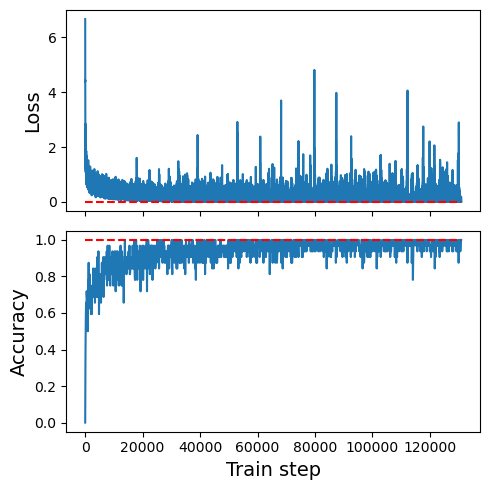

In [45]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

In [46]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
15006,345338,308.710205,-41.807751,90,z,2012B-0001,survey,0.48,0.91,2014-08-08 03:06:01,135.176102,17.780001,-16.722918,1.05,0.91,-0.03,0.69,0.48,1407467161,2014-08-07
15007,345339,308.415405,-42.534832,90,z,2012B-0001,survey,0.50,0.90,2014-08-08 03:07:59,138.204498,17.760000,-15.954292,1.05,0.90,-0.02,0.68,0.50,1407467279,2014-08-07
15008,345340,300.516998,-51.665138,45,Y,2012B-0001,survey,0.63,0.88,2014-08-08 03:10:23,167.548401,22.150000,-7.479875,1.08,0.88,0.00,0.44,0.63,1407467423,2014-08-07
15009,345341,301.753082,-52.138580,45,Y,2012B-0001,survey,0.63,0.89,2014-08-08 03:11:37,166.505798,22.780001,-8.412000,1.08,0.89,0.02,0.42,0.63,1407467497,2014-08-07
15010,345342,301.406647,-54.167442,45,Y,2012B-0001,survey,0.60,0.91,2014-08-08 03:12:51,168.965698,24.590000,-7.767083,1.10,0.91,0.00,0.43,0.60,1407467571,2014-08-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16310,353568,305.568604,-53.693970,90,r,2012B-0001,survey,0.00,1.10,2014-08-31 01:49:06,165.277496,24.620001,-10.242250,1.10,1.10,5.39,1.41,0.00,1409449746,2014-08-30
16311,353570,307.115326,-49.331776,90,z,2012B-0001,survey,0.00,0.94,2014-08-31 01:53:23,159.941299,20.760000,-10.693958,1.07,0.94,3.67,0.28,0.00,1409450003,2014-08-30
16312,353571,307.187317,-47.302803,90,r,2012B-0001,survey,0.00,1.06,2014-08-31 01:55:23,157.897903,18.830000,-10.260750,1.06,1.06,5.80,1.22,0.00,1409450123,2014-08-30
16313,353573,313.426453,-50.650612,90,z,2012B-0001,survey,0.01,1.03,2014-08-31 01:59:31,154.754700,23.480000,-15.478375,1.09,1.03,2.63,0.20,0.01,1409450371,2014-08-30


In [47]:
import random

In [48]:
eval_actions = []
success_sequence = []
azel_sequence = [(az, el) for az, el in zip (dataset.states[:, 0], dataset.states[:, 1])]

with torch.no_grad():
    for i, state in enumerate(dataset.states):
        q_vals = agent.algorithm.policy_net(state.to(device)).unsqueeze(0)
        action = torch.argmax(q_vals, dim=1).item()
        eval_actions.append(action)
        
        # candidates_in_bin = np.array(dataset.id2azel[action])
        # success_sequence.append(azel_sequence[i] in candidates_in_bin)

In [54]:
first_obs_in_night_indices = []
for key, indices in dataset._groups.indices.items():
    first_obs_in_night_indices.append(indices[0])

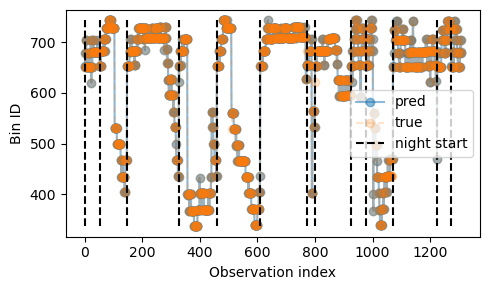

In [67]:
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions
mask_first_obs = dataset.states[:, 0] == 0. 

fig, axs = plt.subplots(1, figsize=(5,3))
axs.plot(eval_sequence, marker='o', label='pred', alpha=.5)
axs.plot(target_sequence, marker='o', linestyle='dashed', label='true', alpha=.2)
axs.set_xlabel('Observation index')
axs.set_ylabel('Bin ID')
axs.vlines(first_obs_in_night_indices, ymin=np.min(eval_sequence), ymax=np.max(eval_sequence), linestyle='--', color='black', label='night start')
axs.legend()

# axs[1].plot(eval_sequence - target_sequence, marker='o')
# axs[1].legend()
# axs[1].set_xlabel('obs index')
# axs[1].set_ylabel('pred - true')

fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')